#                                                **DEEP LEARNING PROJECT-2**


---







*   **NAVEEN BALARAJU**(UB:50251459)
*   **AVINASH KAMMARDI SASHIPRAKASH**(UB:50292823)





# **PROPOSED U-NET MODEL**


*   We proposed a U-net model that gives a Better result compared to the Normal Unet and MultiRes Unet model.
*   Our proposed model consists of a Dowsampling Path, Proposed Multires Upath and an Upsampling Path.


*   **Down Sampling Block**: The architecture of the Downsampling block has been shown below
       
                      Conv_layer
                          |
                Batch Normalization
                          |
                     Conv_layer
                          |
                   Max pooling layer



*   The Downsampling path consists of 4 Downsampling blocks and we encourange you to look at our model plot for more information.

*   **Up Sampling Block**:The architecture of the Upsampling block has been shown below
         Skip connection + Input from previous Conv_layer
                         |
                Batch Normalization
                         |
                    Conv_layer
                         |
                 Batch Normalization
                         |
                     Conv_layer
                         |
                  Up sampling layer


*   The Up-sampling path consists of 4 Up sampling blocks and we encourange you to look at our model plot for more information.


*   **Proposed MultiRes Path**: The inspiration to this is architecture is derived from this paper:https://arxiv.org/pdf/1902.04049.pdf. However, The skip connections that we have defined is different interms of its architecture.

*   In Their paper,the authors have used Respaths that connects the Encoder and Decoder in the following manner:
1. The first Respath contains 4 conv_layers with 32 filters each
2. The Second Respath contains 3 conv_layers with 64 filters each 
3. The Third Respath contains 2 conv_layers with 128 filters each
4. The fourth Respath contains 1 conv_layers with 256 filters each



*   In the model that we have proposed, we have used the Respaths in the following manner:
1. The first Respath contains 1 conv_layers with 32 filters each
2. The Second Respath contains 2 conv_layers with 64 filters each 
3. The Third Respath contains 3 conv_layers with 128 filters each
4. The fourth Respath contains 4 conv_layers with 256 filters each



*   **Explanation for the choosen architecture**: The convolution neural networks only learns low level features such as lines, edges and corners in the earlier layers.Furthermore, as the networks grows in depth, the convolution neural networks can capture more and a finer context present in an image.Hence, we felt using more number of conv_layers in the first Respath was not a good idea and we have only used 1 conv_layer in the first Respath,2 conv_layer in the second Respath,3 conv_layer in the third Respath and 4 conv_layers in the 4th Respath that contains more context of the image.Also, this model architecture resulted in a imporved performance and we achieved a highest validation Dice score of 0.8702















































# DEPENDENT PACKAGES

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import cv2
from keras import layers
from keras.models import Sequential
from keras.models import Input
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import ReLU
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.layers import Reshape
from keras.layers import add
from keras.utils import plot_model
from keras.optimizers import Adam
import pickle
import os
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.models import load_model
from proposedmodel import Proposed_UNET_model
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow

# MOUNTING TO DRIVE

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# HYPERPARAMETERS

In [0]:
imagesize = 256
batch_size = 32
Optimizer = Adam(lr=1e-5)
epoch = 120

# DATA LOADING,PRE-PROCESSING AND SPLITTING THE DATA

In [0]:
pkl_img = open('Image.pickle','rb')
Final_image_data = pickle.load(pkl_img)

pkl_img = open('Mask.pickle','rb')
Final_mask_data = pickle.load(pkl_img)

print(f'Shape of training images: {Final_image_data.shape}')
print(f'Shape of training mask: {Final_mask_data.shape}')

Shape of training images: (3929, 256, 256, 1)
Shape of training mask: (3929, 256, 256, 1)


In [0]:
# Normalizing the Data

Final_image_data = Final_image_data/255.0
Final_mask_data = Final_mask_data/255.0

# Splitting The dataset

Training_images,Validation_images,Training_mask,Validation_masks = train_test_split(Final_image_data,Final_mask_data,test_size=0.15,random_state=42)
del(Final_image_data)
del(Final_mask_data)
Validation_images,Test_images,Validation_masks,Test_masks = train_test_split(Validation_images,Validation_masks,test_size=0.15,random_state=42)


print(f'Training Images shape:{Training_images.shape}')
print(f'Training Mask shape:{Training_mask.shape}')
print(f'Validation Images shape:{Validation_images.shape}')
print(f'Validation Mask shape:{Validation_masks.shape}')
print(f'Test Images shape:{Test_images.shape}')
print(f'Test Mask shape:{Test_masks.shape}')

Training Images shape:(3339, 256, 256, 1)
Training Mask shape:(3339, 256, 256, 1)
Validation Images shape:(501, 256, 256, 1)
Validation Mask shape:(501, 256, 256, 1)
Test Images shape:(89, 256, 256, 1)
Test Mask shape:(89, 256, 256, 1)


# DATA AUGMENTATION

In [0]:

data_gen_args = dict(featurewise_center=True,featurewise_std_normalization=True,rotation_range=45,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


seed = 6
batch_size = 32



image_generator = image_datagen.flow(Training_images,seed=seed,batch_size=batch_size,shuffle = True)
mask_generator = mask_datagen.flow(Training_mask,seed=seed,batch_size=batch_size,shuffle = True)


# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# LOSS FUNCTION

In [0]:
smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# **PROPOSED U-NET** 

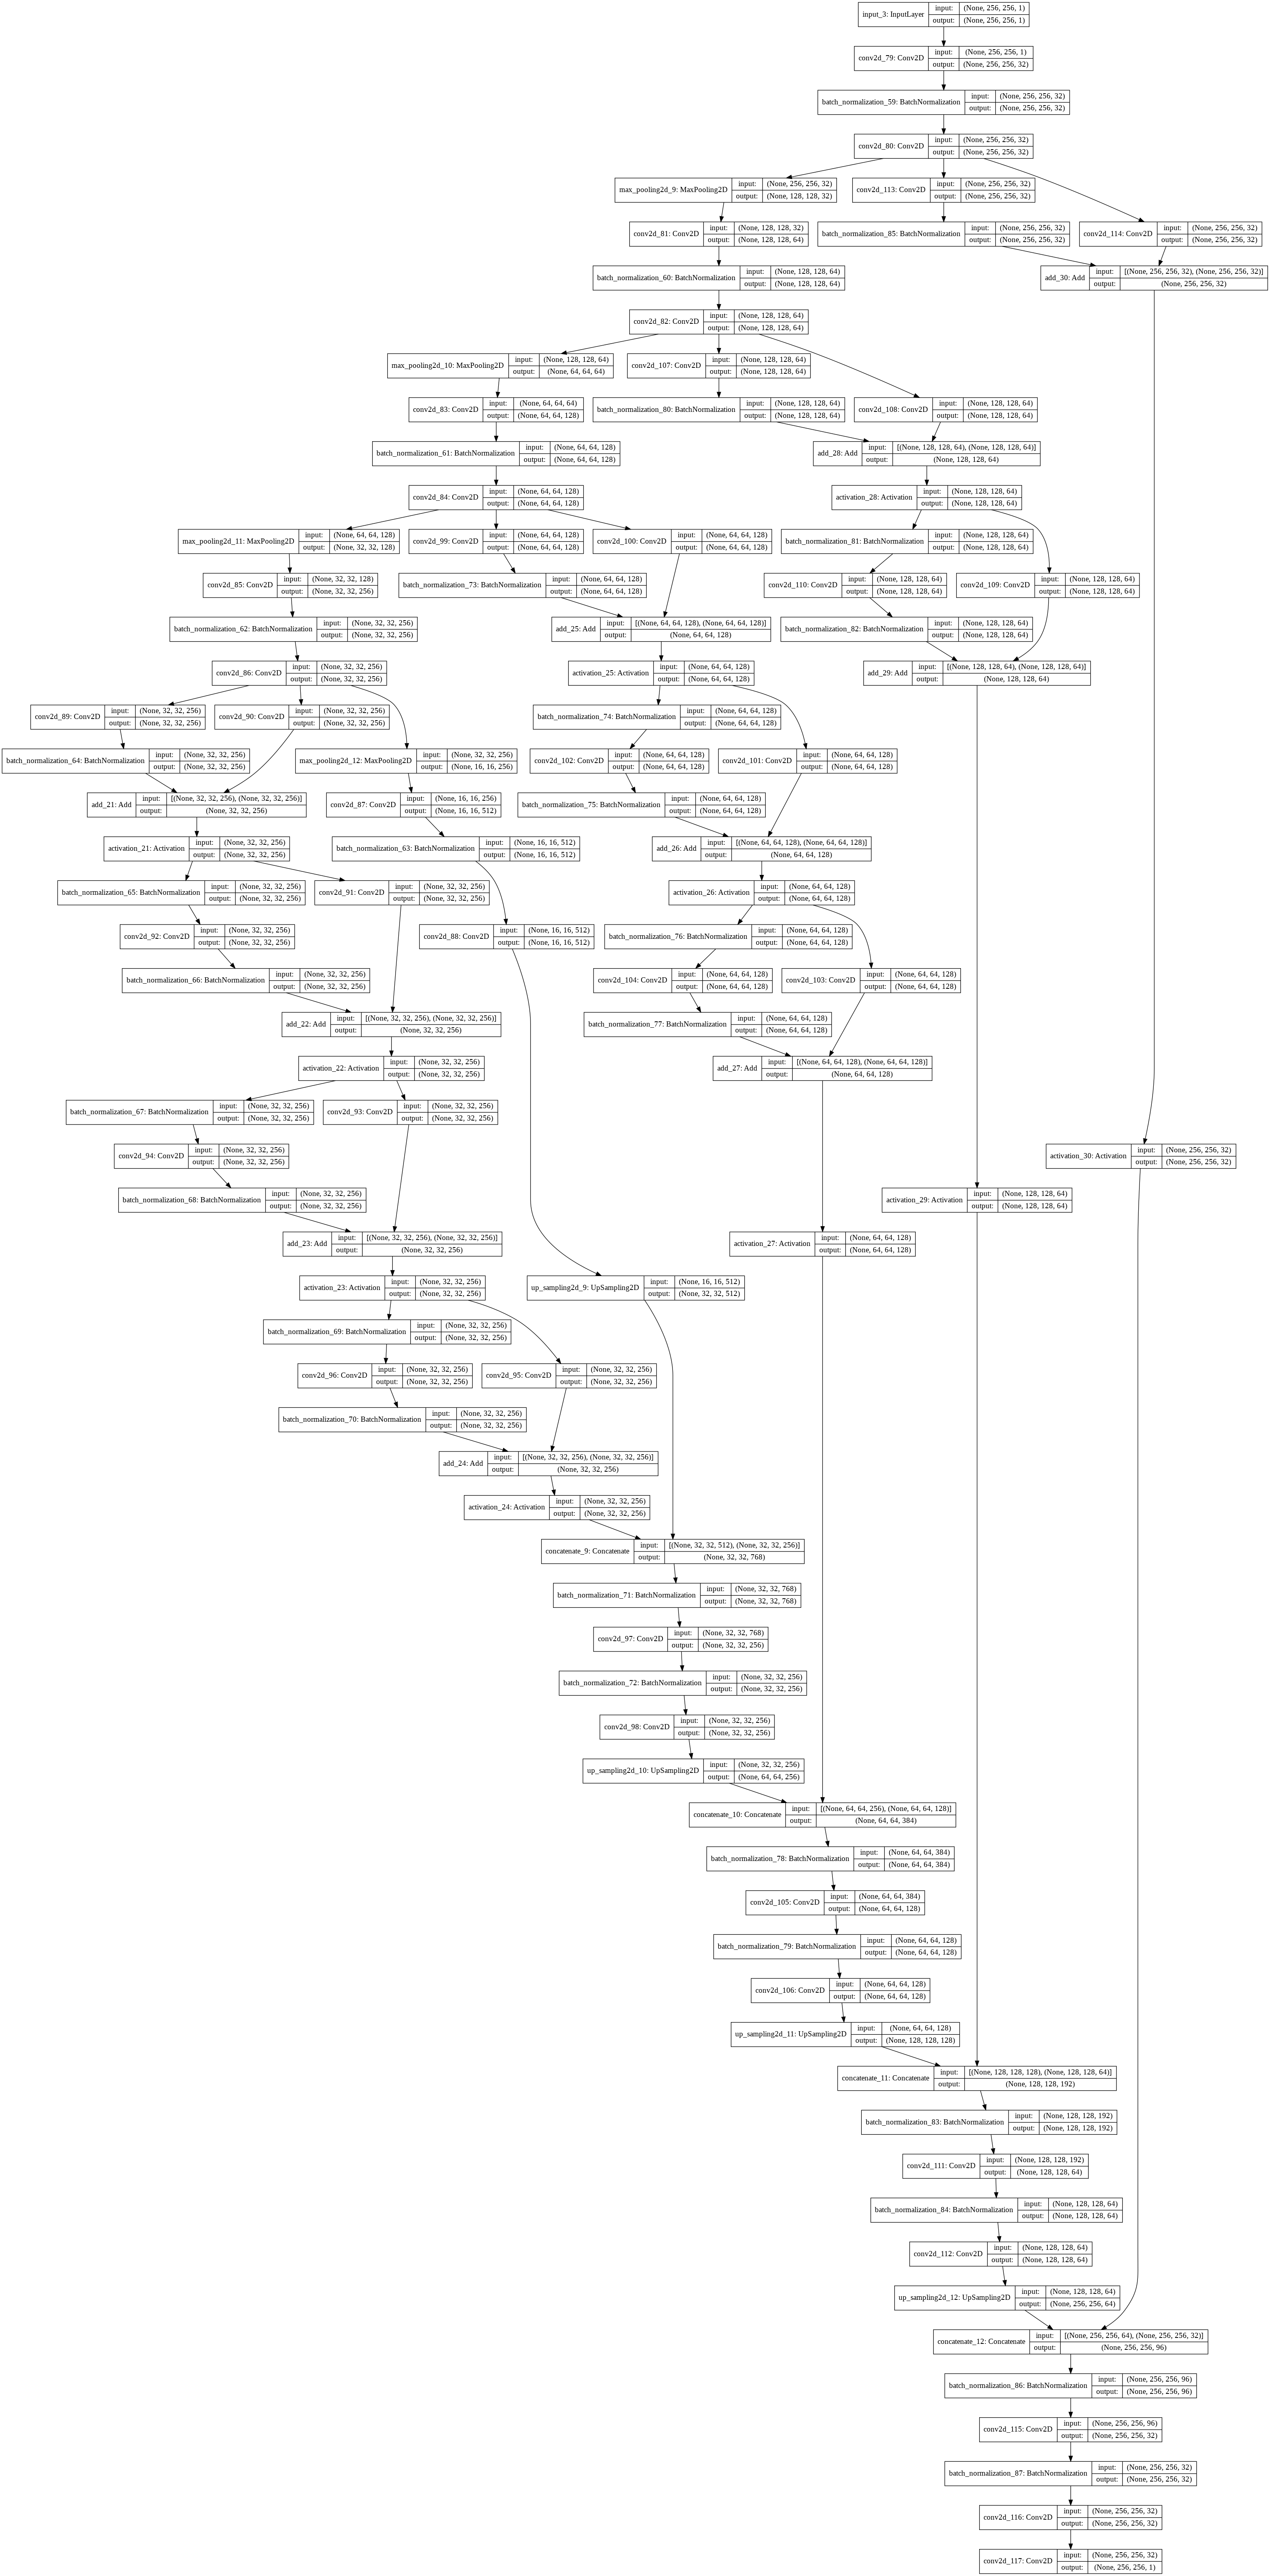

In [8]:
Proposed_Unet = Proposed_UNET_model()
plot_model(Proposed_Unet,show_shapes=True)

In [9]:
Proposed_Unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 256, 256, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 256, 256, 32) 128         conv2d_79[0][0]                  
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 256, 256, 32) 9248        batch_normalization_59[0][0]     
____________________________________________________________________________________________

# PROPOSED UNET MODEL TRAINING

In [0]:
Proposed_Unet.compile(optimizer=Optimizer,loss=dice_coef_loss,metrics=[dice_coef])

In [0]:

Unet_training = Proposed_Unet.fit_generator(train_generator,steps_per_epoch=(len(Training_images)//batch_size),epochs=epoch,verbose = 1,validation_data=(Validation_images,Validation_masks))

# Saving the trained Proposed Unet model
path_save_model = '/content/drive/My Drive/Colab Notebooks/Proposed_Model_Training'
Proposed_Unet.save(os.path.join(path_save_model,"PropUnet_trained_model_with_dataaug_120epoch.h5"))
print('Successfuly saved the trained Unet model into the Drive..!!!!!!!')



Epoch 1/120


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


104/104 [==============================] - 84s 809ms/step - loss: -0.0556 - dice_coef: 0.0556 - val_loss: -0.1020 - val_dice_coef: 0.1020
Epoch 2/120
104/104 [==============================] - 69s 668ms/step - loss: -0.1455 - dice_coef: 0.1455 - val_loss: -0.2506 - val_dice_coef: 0.2506
Epoch 3/120
104/104 [==============================] - 68s 656ms/step - loss: -0.3269 - dice_coef: 0.3269 - val_loss: -0.4472 - val_dice_coef: 0.4472
Epoch 4/120
104/104 [==============================] - 68s 657ms/step - loss: -0.4935 - dice_coef: 0.4935 - val_loss: -0.5232 - val_dice_coef: 0.5232
Epoch 5/120
104/104 [==============================] - 68s 656ms/step - loss: -0.5524 - dice_coef: 0.5524 - val_loss: -0.4874 - val_dice_coef: 0.4874
Epoch 6/120
104/104 [==============================] - 68s 657ms/step - loss: -0.6151 - dice_coef: 0.6151 - val_loss: -0.6400 - val_dice_coef: 0.6400
Epoch 7/120
104/104 [==============================] - 68s 656ms/step - loss: -0.6450 - dice_coef: 0.6450 - val_

NameError: ignored

In [0]:
path_save_model = '/content/drive/My Drive/Colab Notebooks/Proposed_Model_Training'
Proposed_Unet.save(os.path.join(path_save_model,"PropUnet_trained_model_with_dataaug_120epoch.h5"))
print('Successfuly saved the trained Unet model into the Drive..!!!!!!!')

Successfuly saved the trained Unet model into the Drive..!!!!!!!


# METRICS AND LOSS PLOTS

In [0]:
train_dice_coef = Unet_training.history['dice_coef']
train_loss = Unet_training.history['loss']

validation_dice_coef = Unet_training.history['val_dice_coef']
validation_loss = Unet_training.history['val_loss']
Number_of_epochs = range(len(train_dice_coef))


# saving the metric values
i = open('train_dice_coef.pickle','wb')
pickle.dump(train_dice_coef,i)
i.close()

i = open('train_loss.pickle','wb')
pickle.dump(train_loss,i)
i.close()

i = open('validation_dice_coef.pickle','wb')
pickle.dump(validation_dice_coef,i)
i.close()


i = open('validation_loss.pickle','wb')
pickle.dump(validation_loss,i)
i.close()

i = open('Number_of_epochs.pickle','wb')
pickle.dump(Number_of_epochs,i)
i.close()

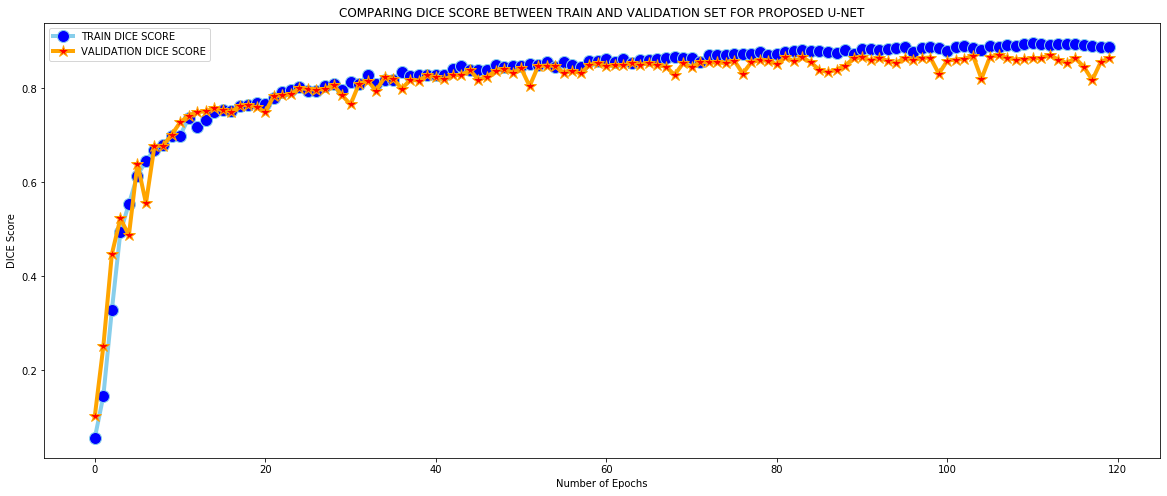

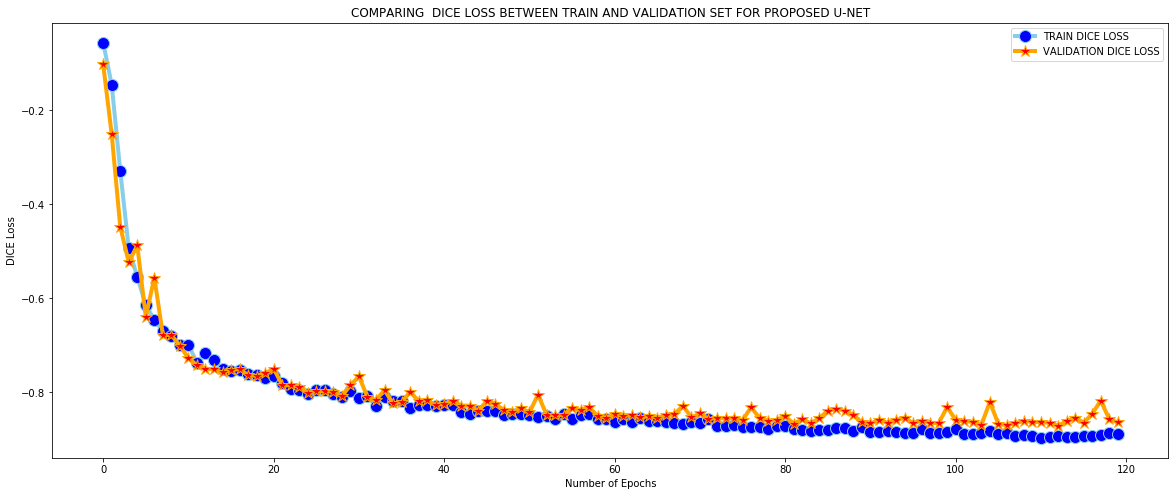

In [0]:
plt.figure(figsize=(20,8))
plt.title('COMPARING DICE SCORE BETWEEN TRAIN AND VALIDATION SET FOR PROPOSED U-NET')
plt.plot(Number_of_epochs,train_dice_coef,marker='o',markerfacecolor='blue',markersize=12,color='skyblue',linewidth=4,label='TRAIN DICE SCORE')
plt.plot(Number_of_epochs,validation_dice_coef,marker='*',markerfacecolor='red',markersize=12,color='orange',linewidth=4,label='VALIDATION DICE SCORE')
plt.xlabel('Number of Epochs')
plt.ylabel('DICE Score')
plt.legend()
plt.savefig('Dice_score.png')
plt.show()



plt.figure(figsize=(20,8))
plt.title('COMPARING  DICE LOSS BETWEEN TRAIN AND VALIDATION SET FOR PROPOSED U-NET')
plt.plot(Number_of_epochs,train_loss,marker='o',markerfacecolor='blue',markersize=12,color='skyblue',linewidth=4,label='TRAIN DICE LOSS')
plt.plot(Number_of_epochs,validation_loss,marker='*',markerfacecolor='red',markersize=12,color='orange',linewidth=4,label='VALIDATION DICE LOSS')
plt.xlabel('Number of Epochs')
plt.ylabel('DICE Loss')
plt.legend()
plt.savefig('Dice_loss.png')
plt.show()

# EVALUATING MODEL PERFORMANCE ON TEST DATA
 Here we have compared the performance of the Proposed Unet model and Unet model both trained for 120 epochs.

In [0]:
saved_proposed_unet_model = load_model("PropUnet_trained_model_with_dataaug_120epoch.h5",custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [0]:
pred = saved_proposed_unet_model.predict(Test_images,verbose=1)

89/89 [==============================] - 3s 34ms/step


In [0]:
saved_unet_model = load_model("Unet_trained_model_120epoch.h5",custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [0]:
pred_unet = saved_unet_model.predict(Test_images,verbose=1)

89/89 [==============================] - 2s 27ms/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


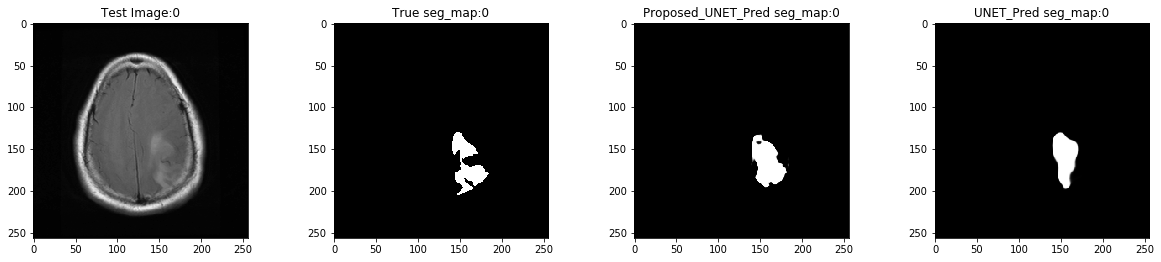

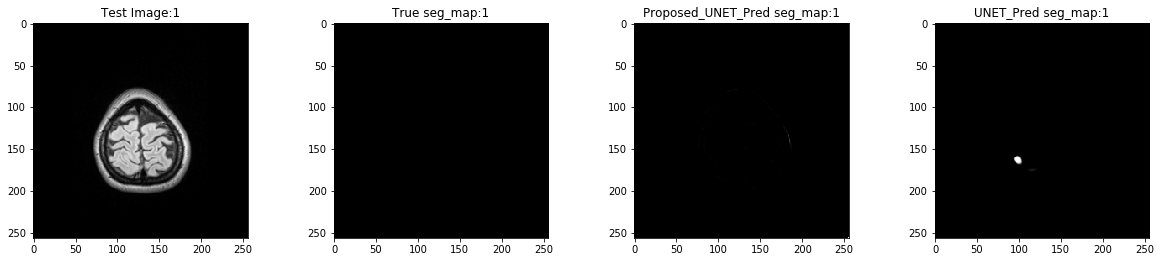

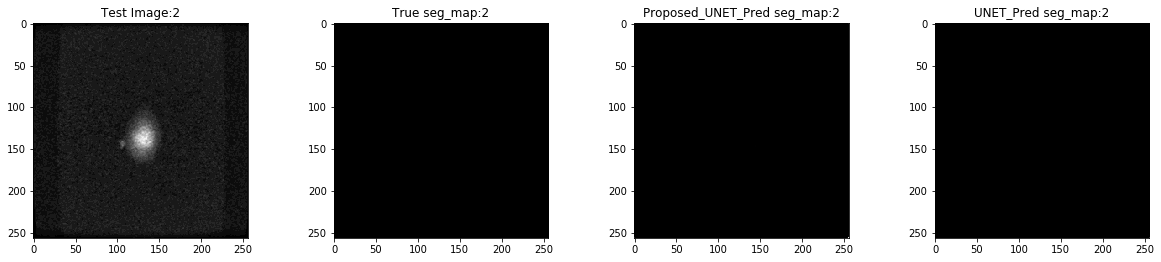

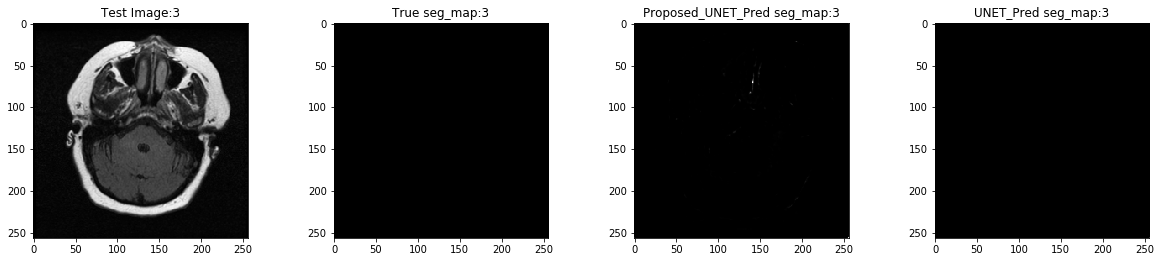

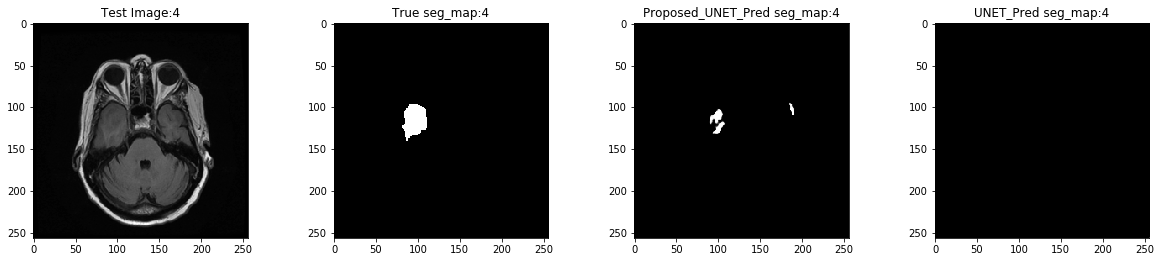

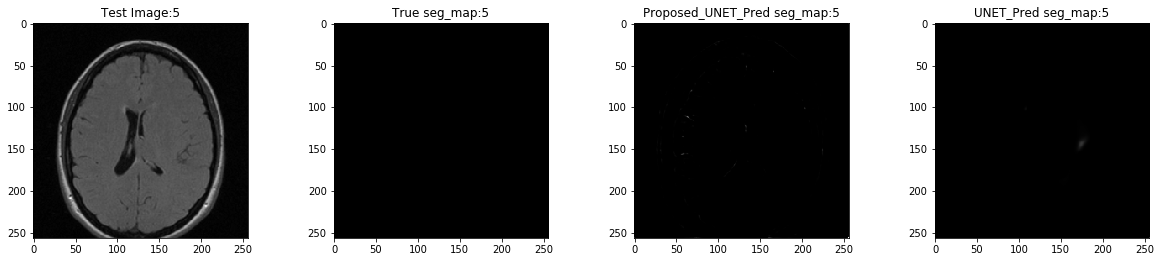

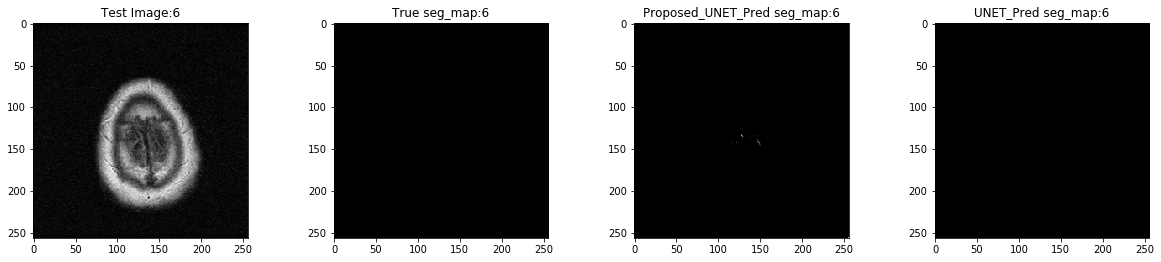

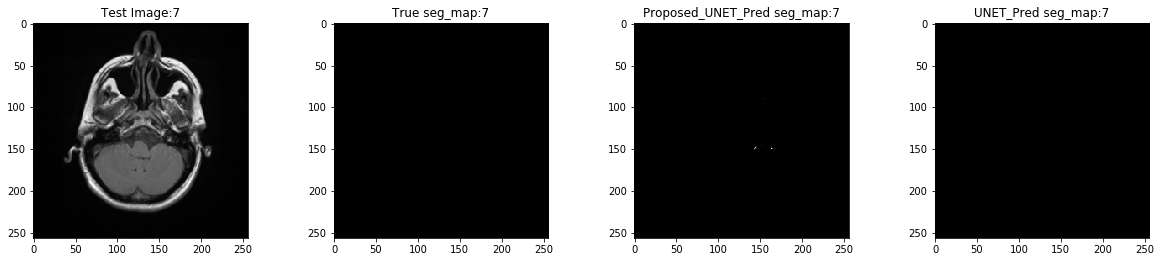

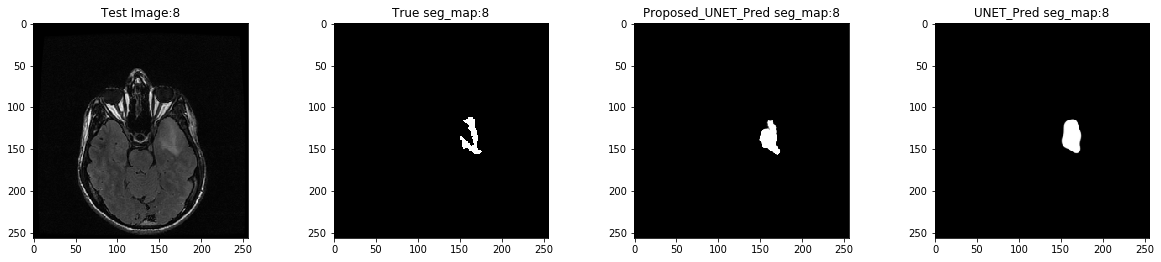

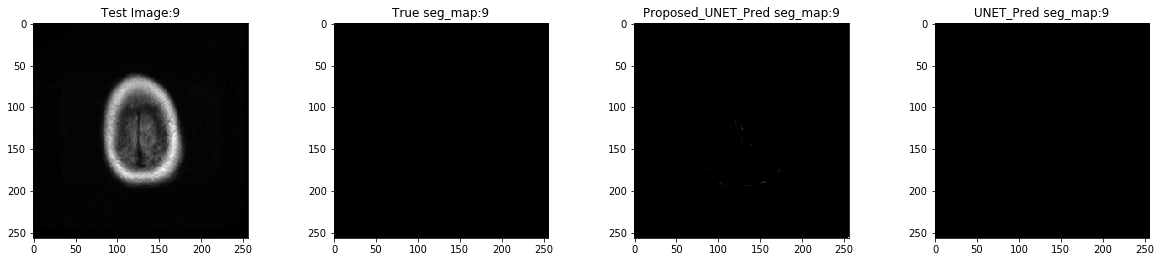

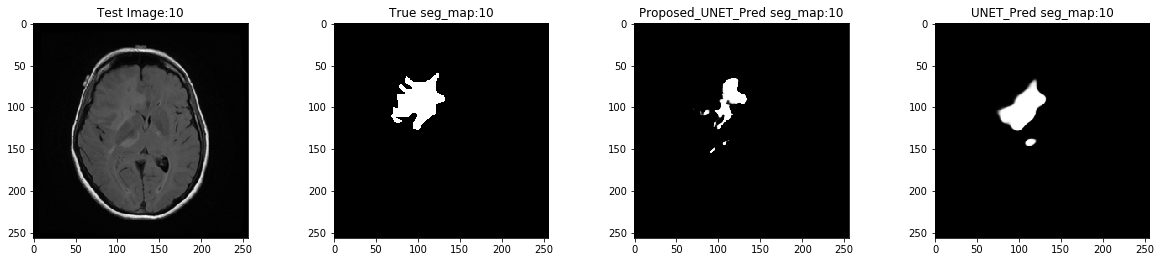

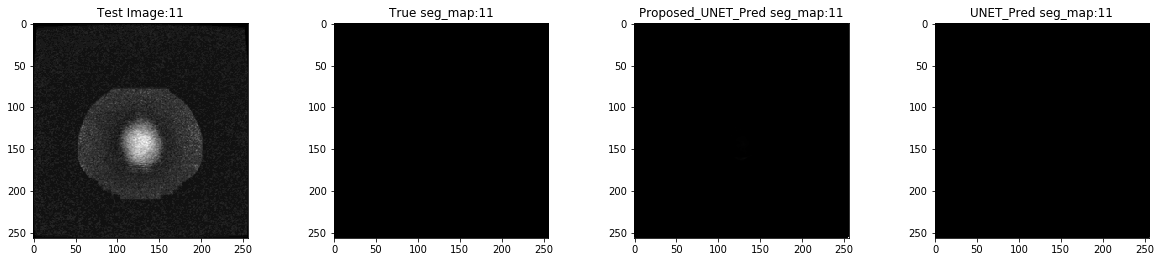

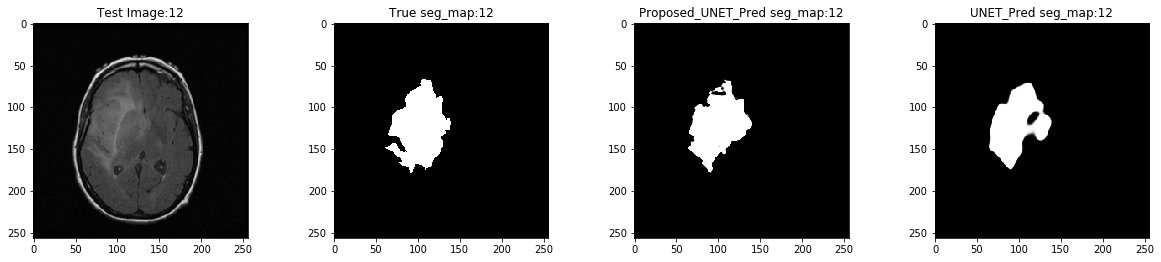

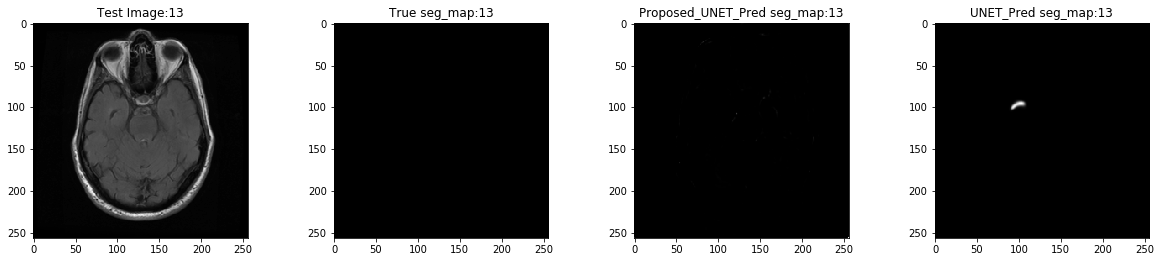

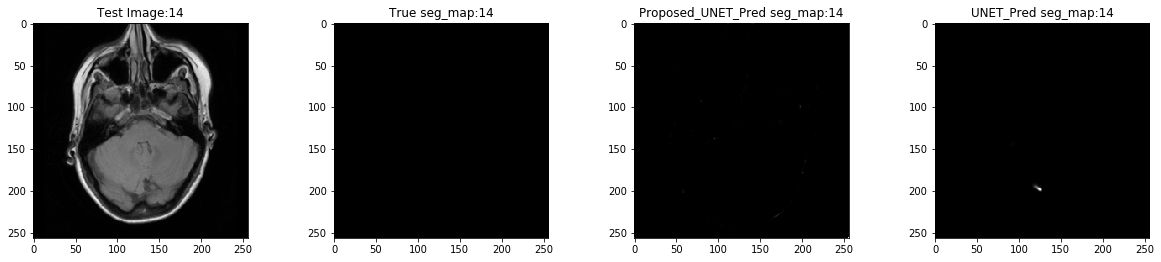

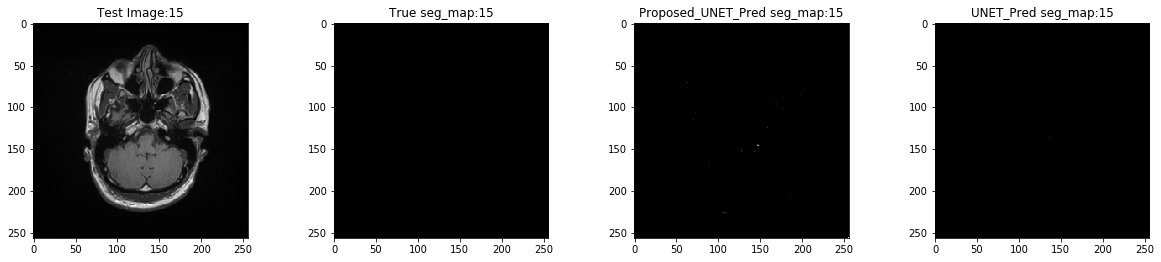

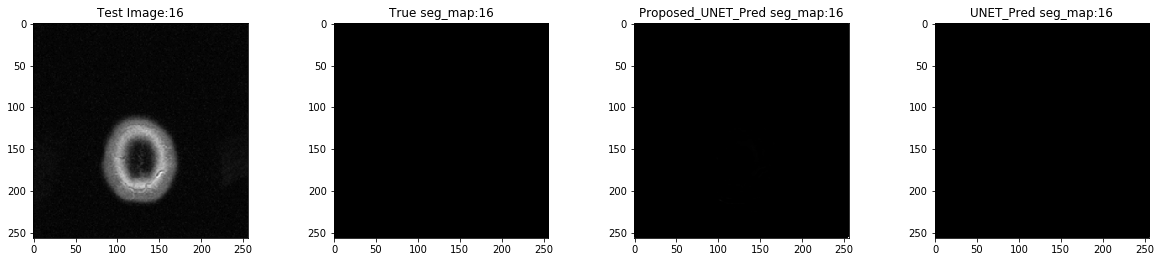

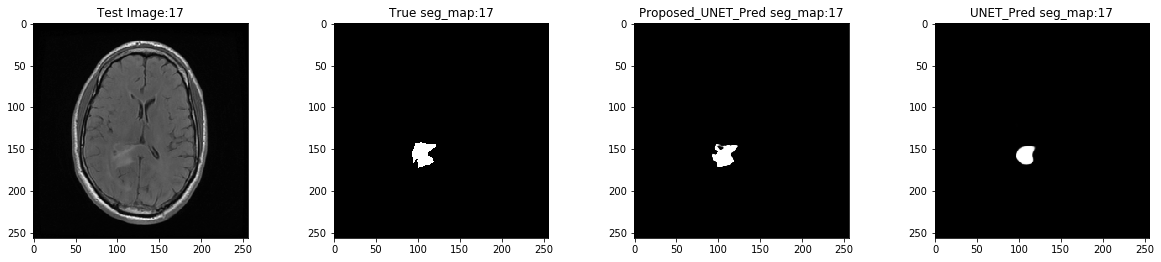

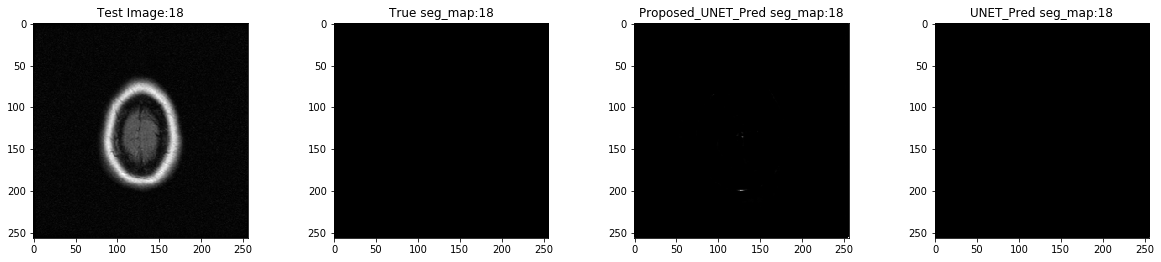

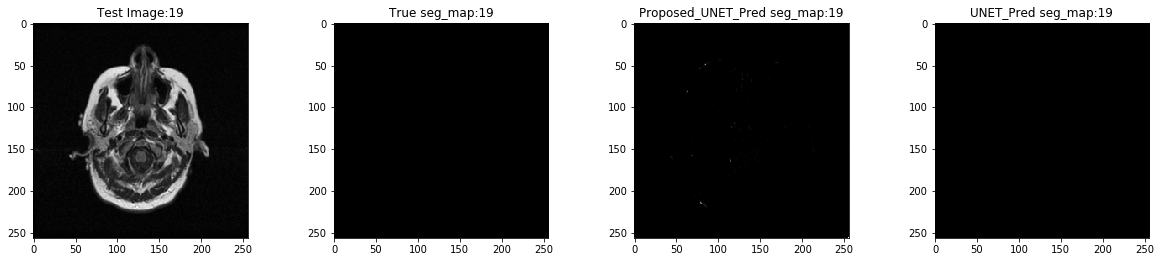

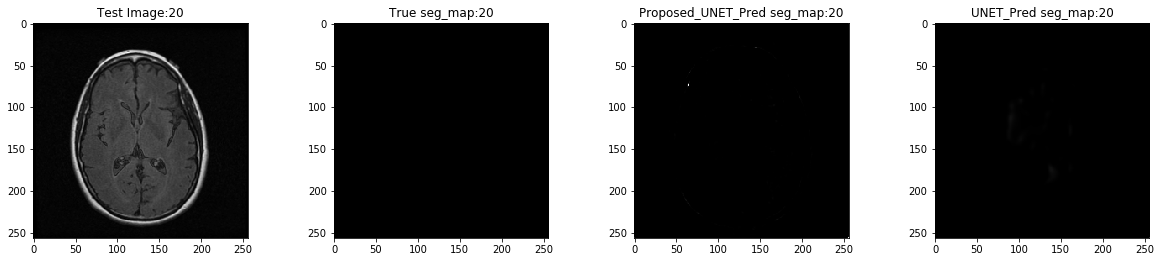

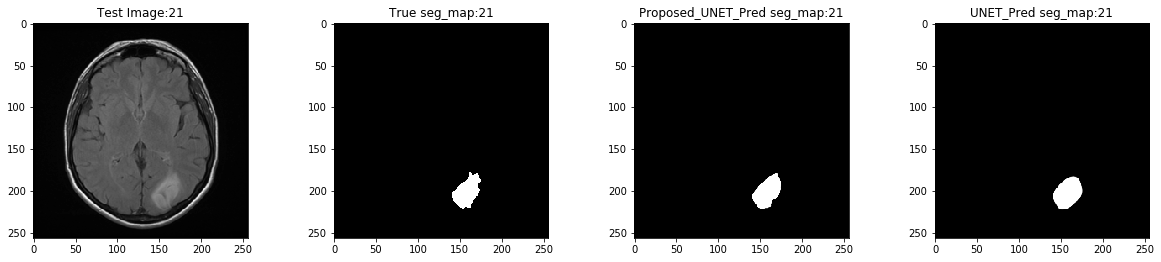

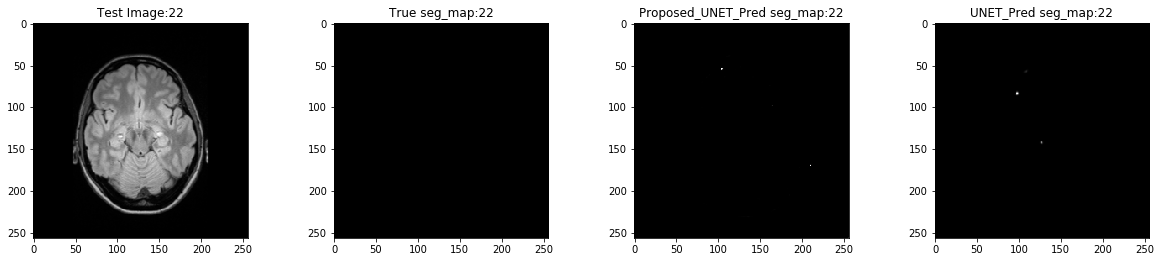

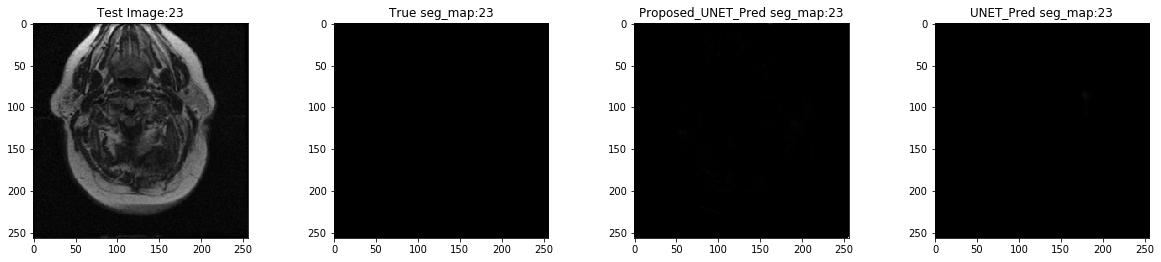

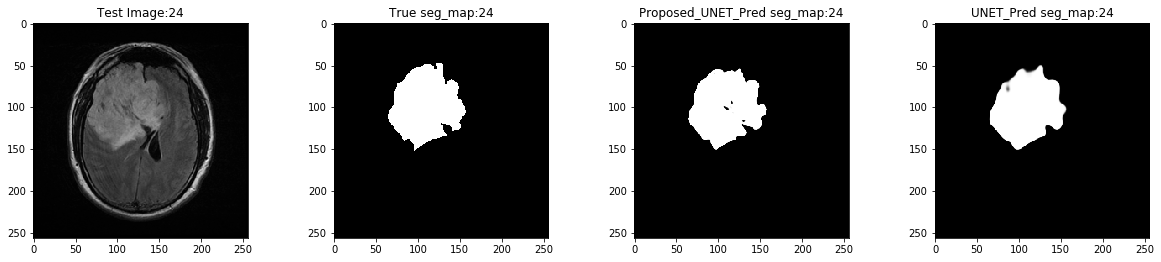

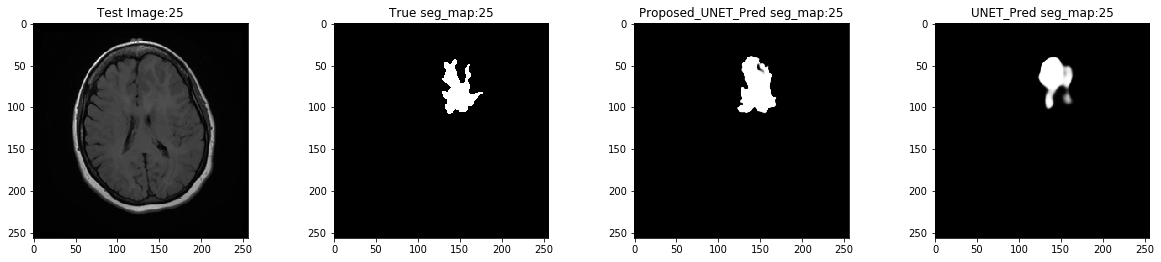

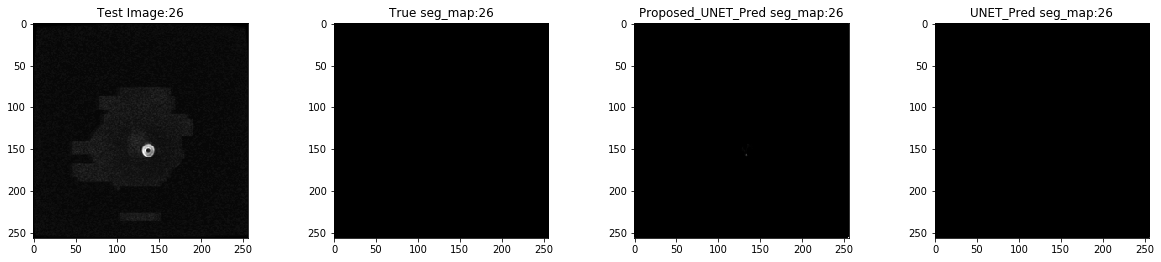

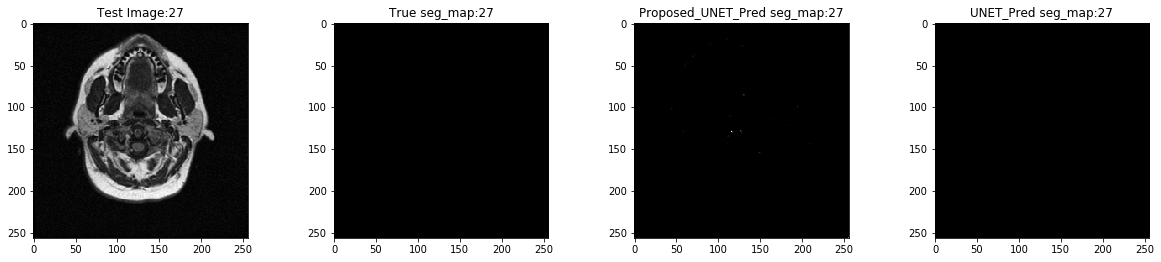

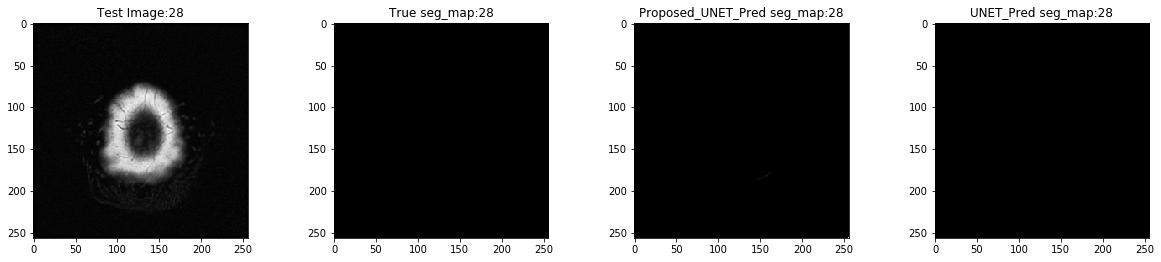

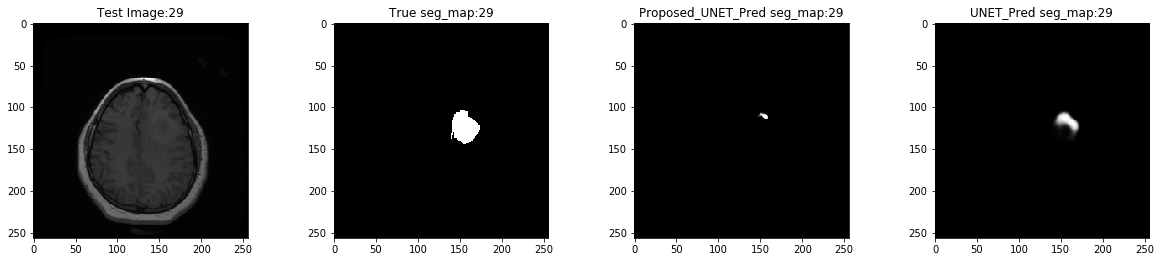

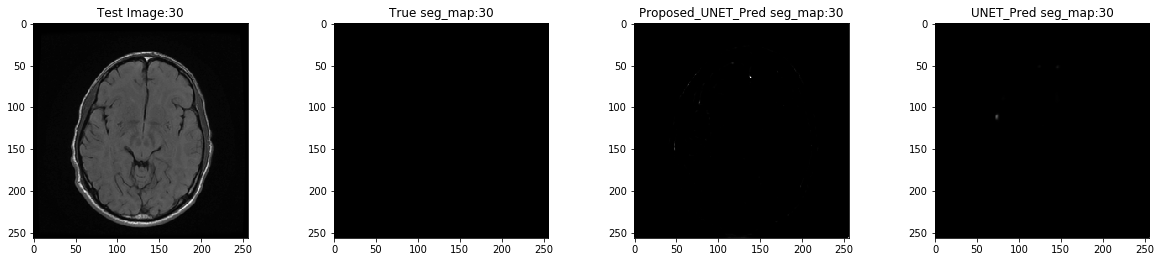

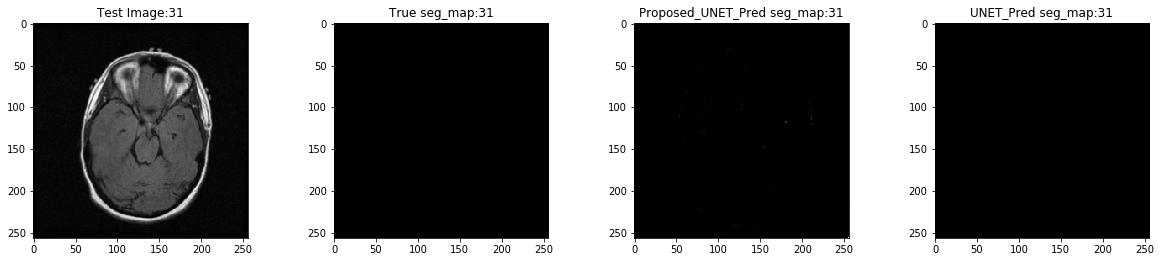

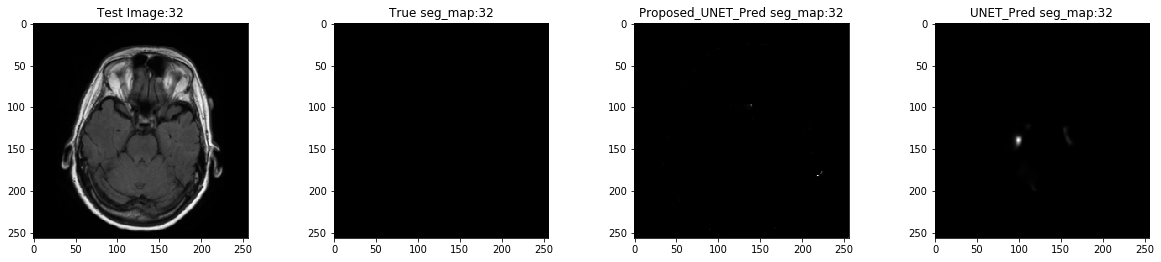

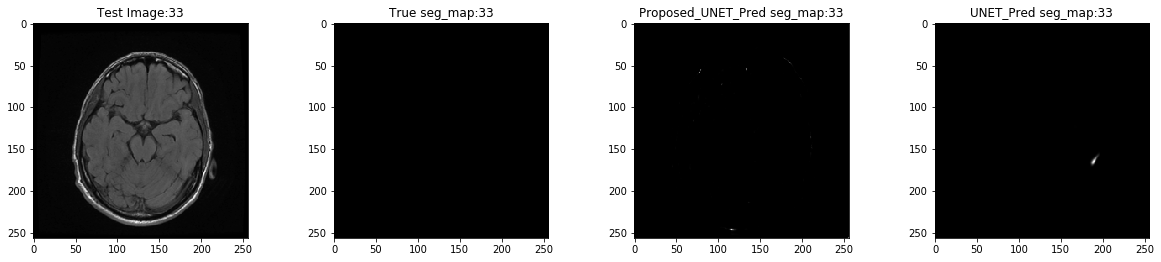

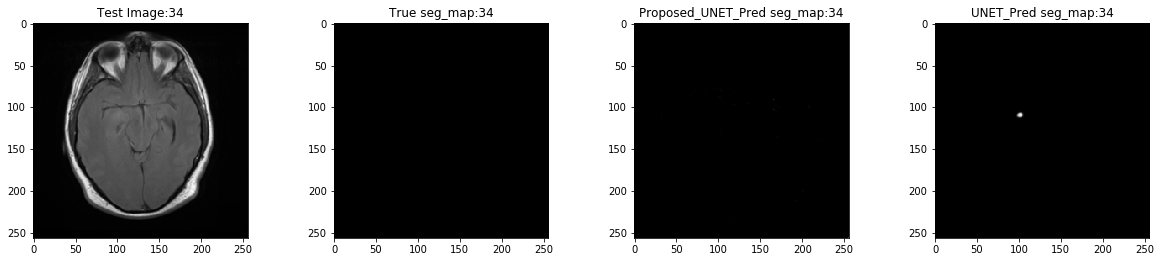

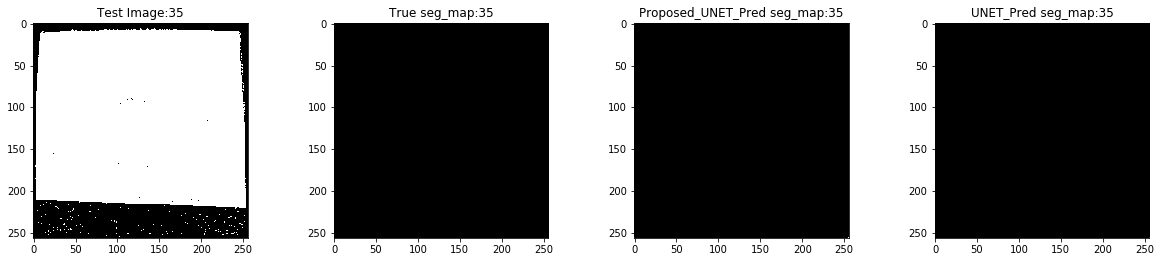

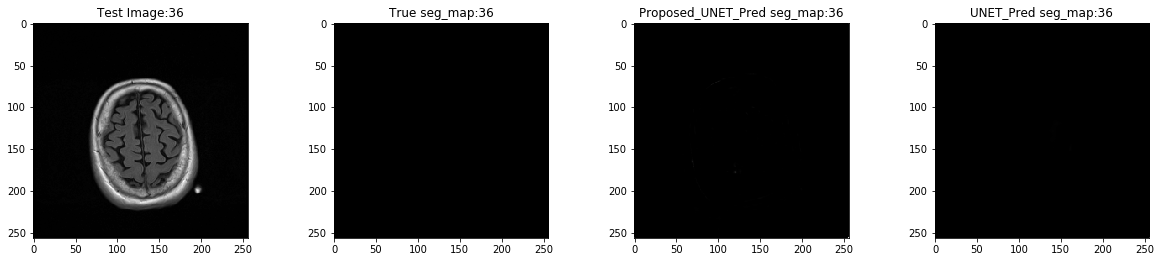

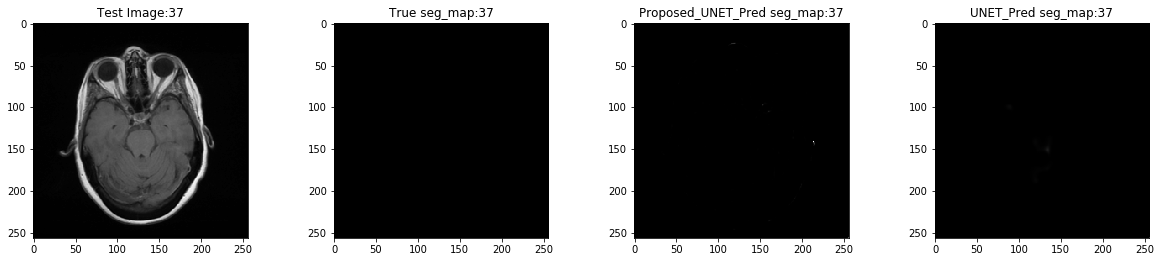

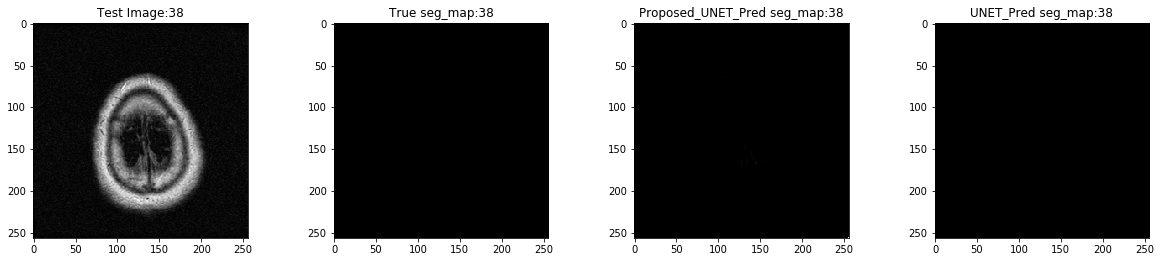

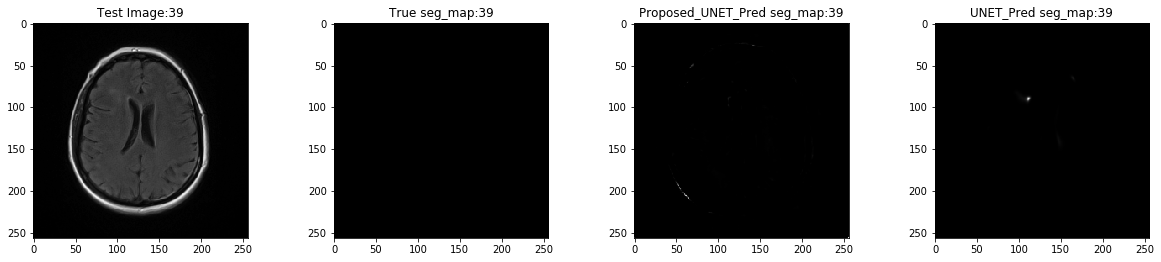

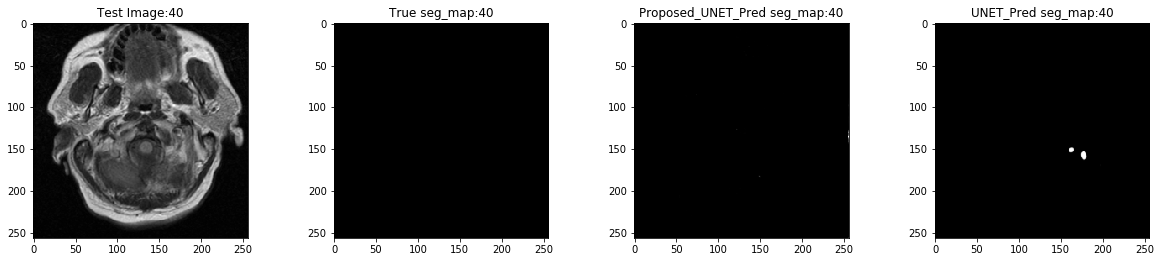

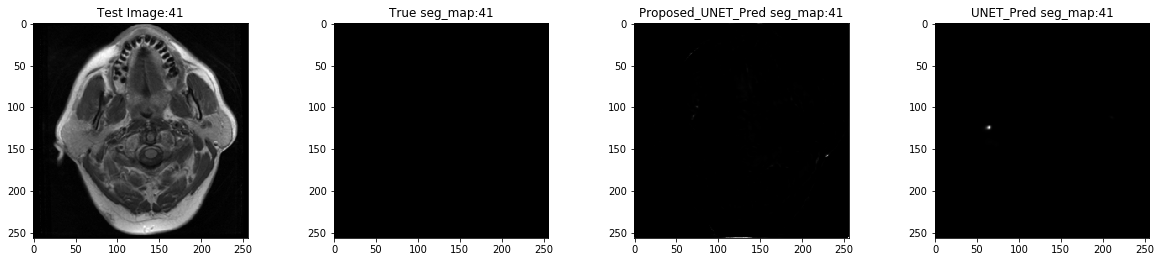

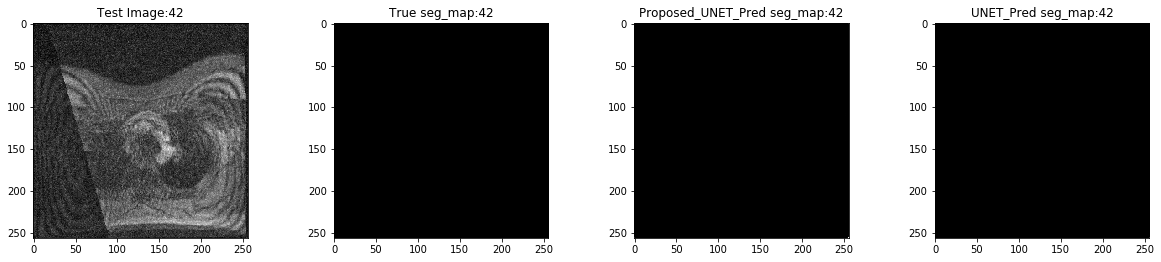

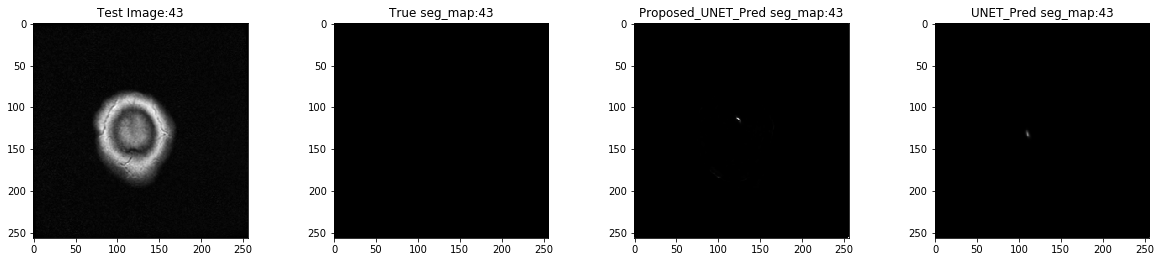

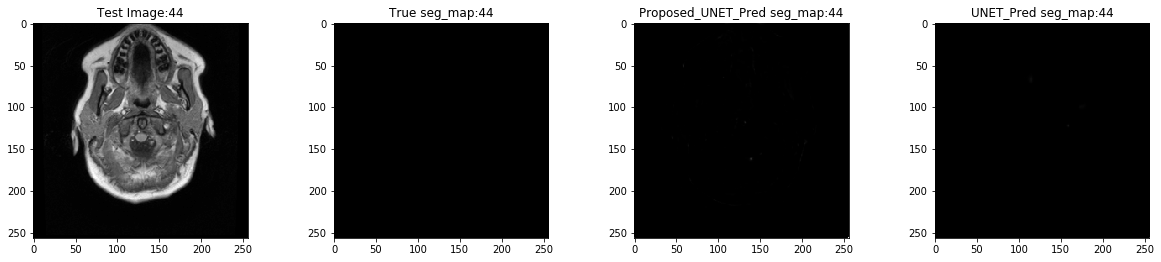

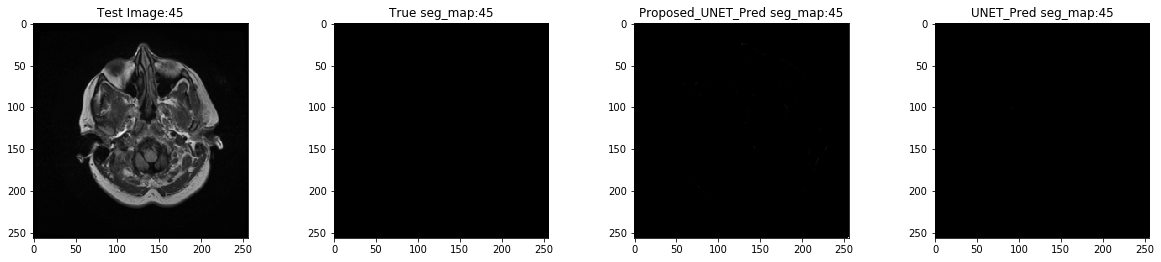

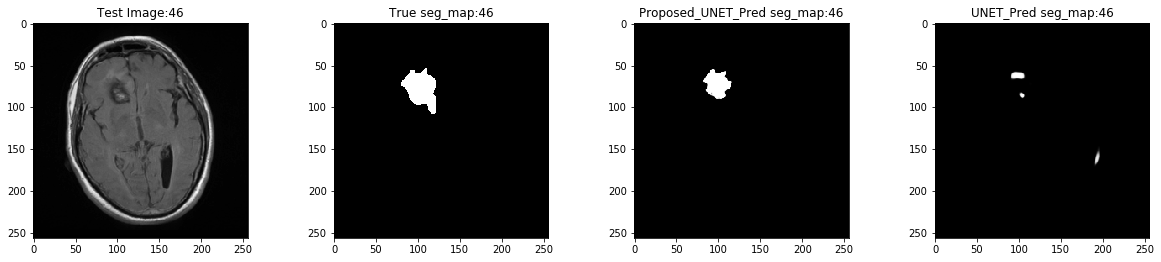

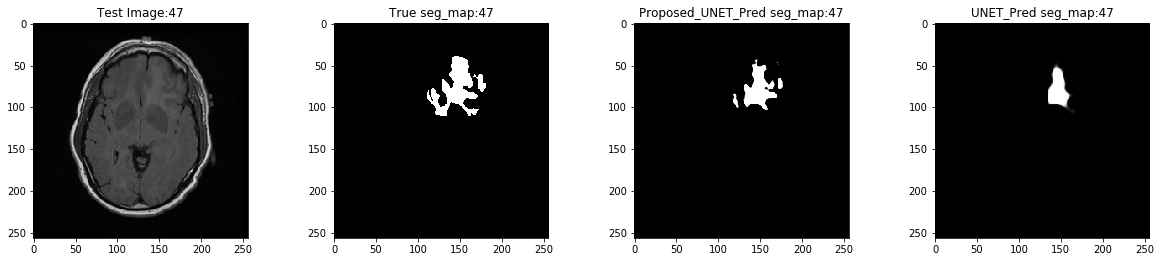

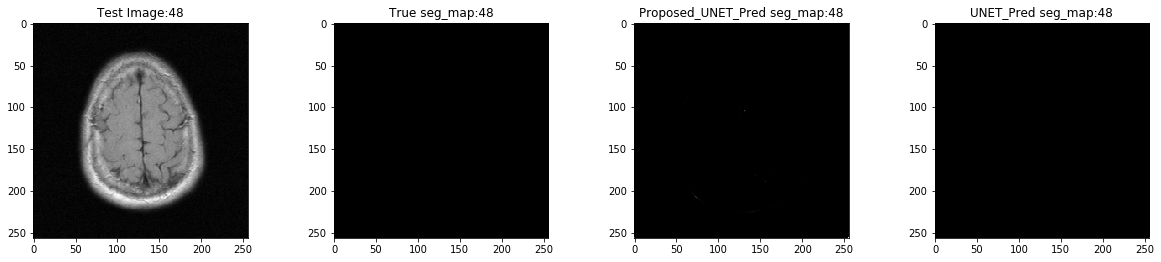

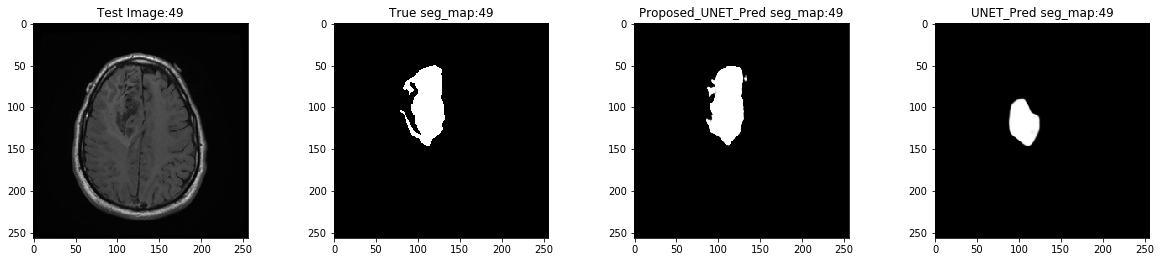

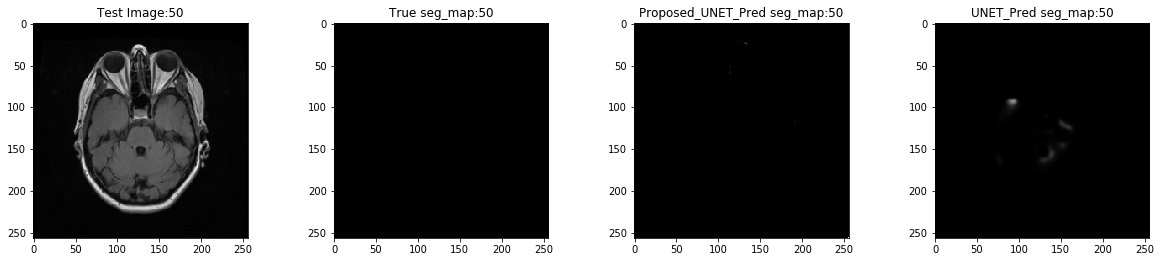

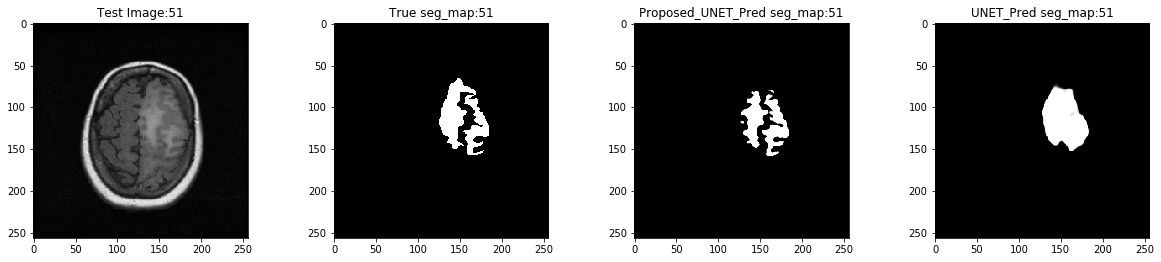

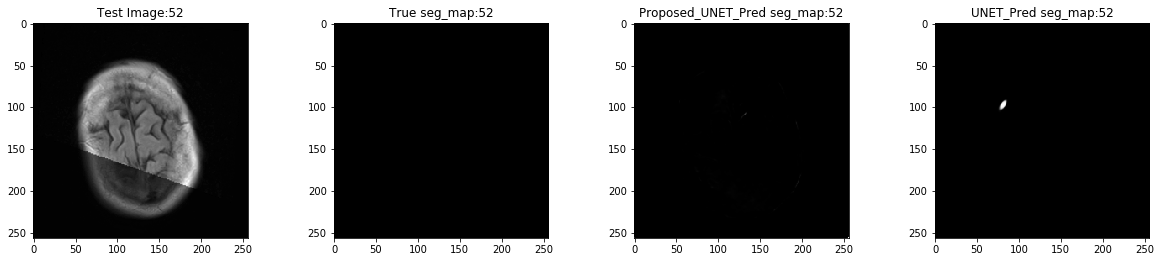

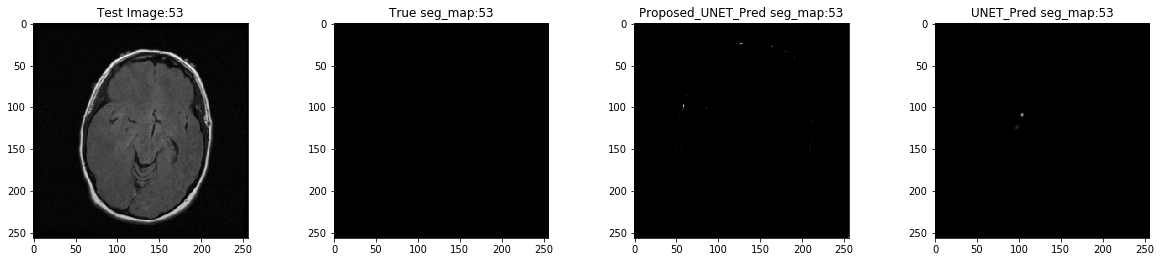

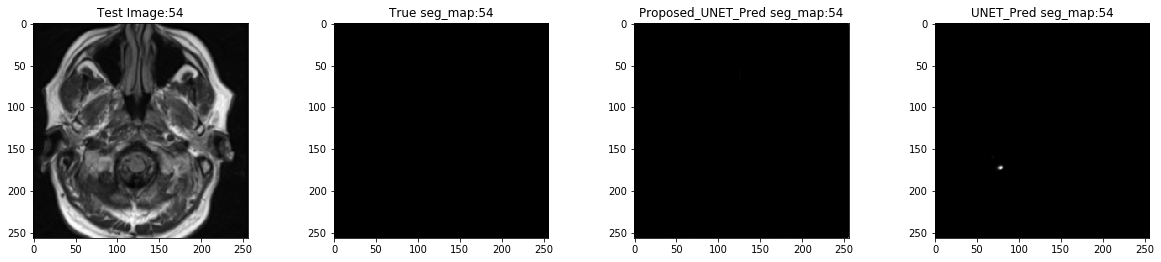

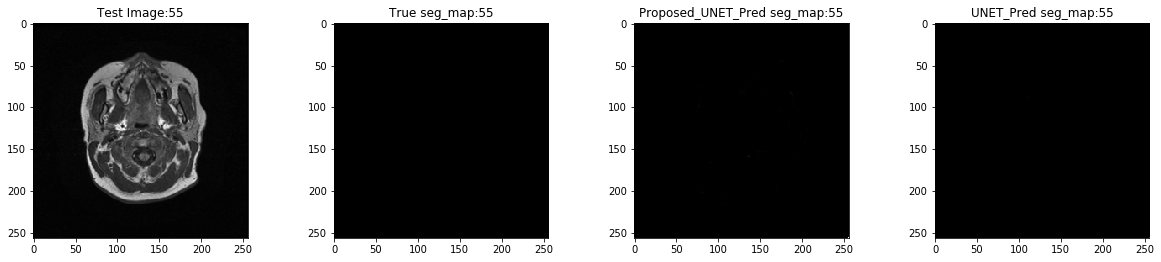

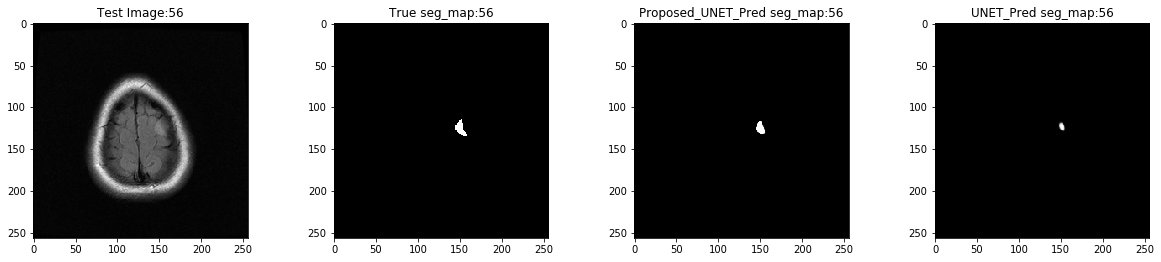

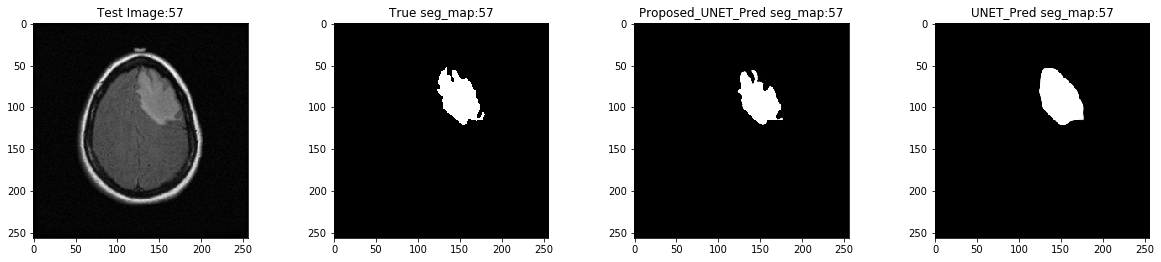

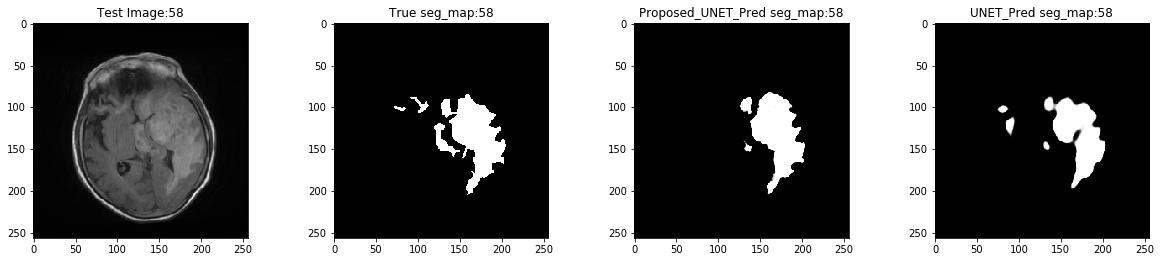

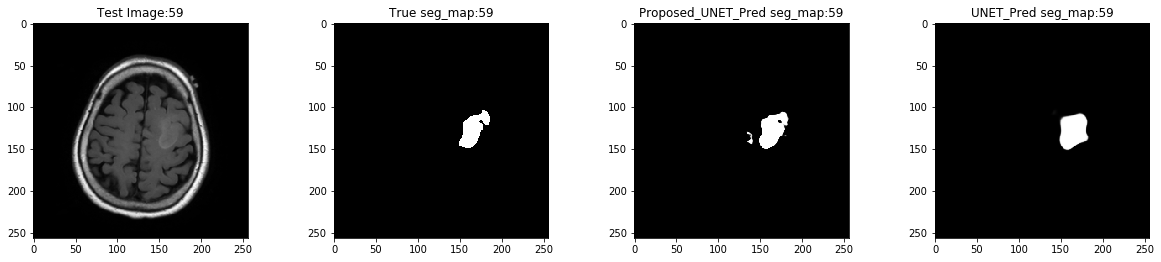

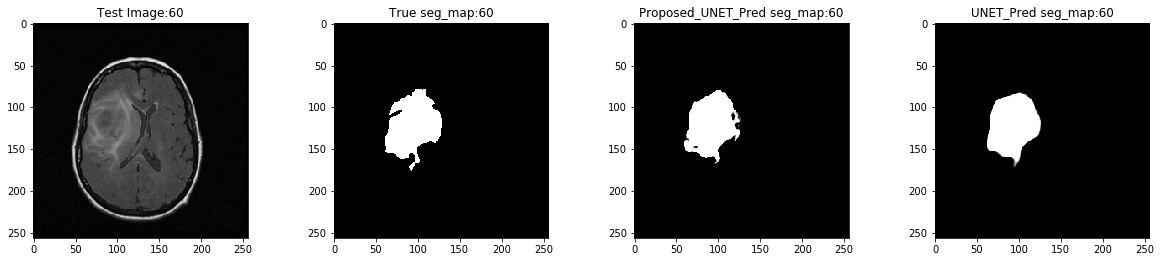

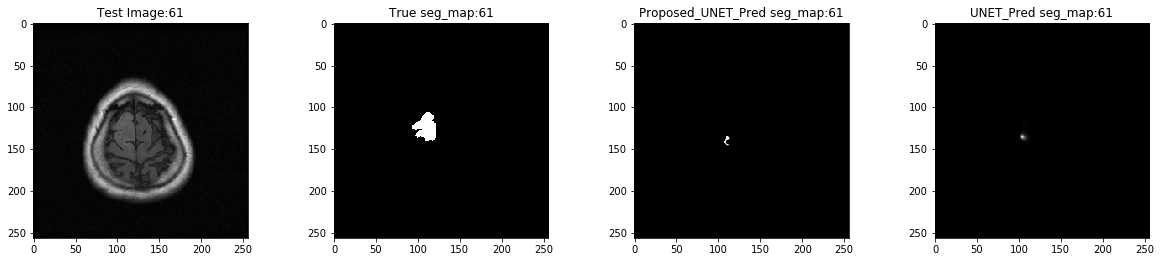

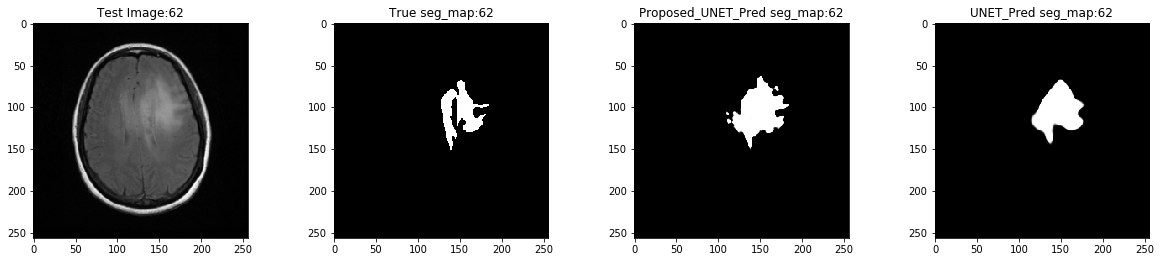

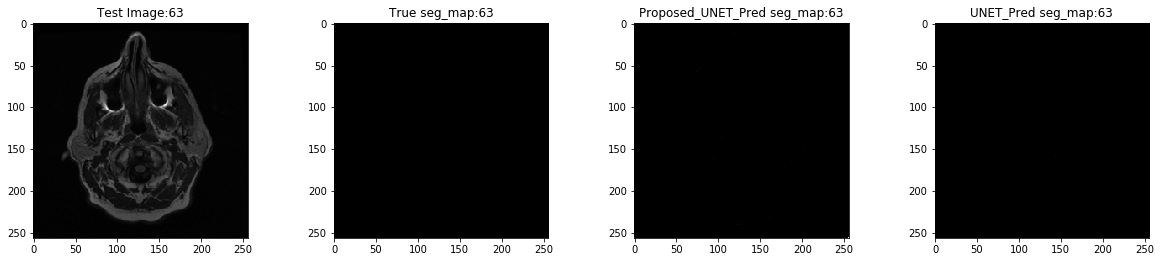

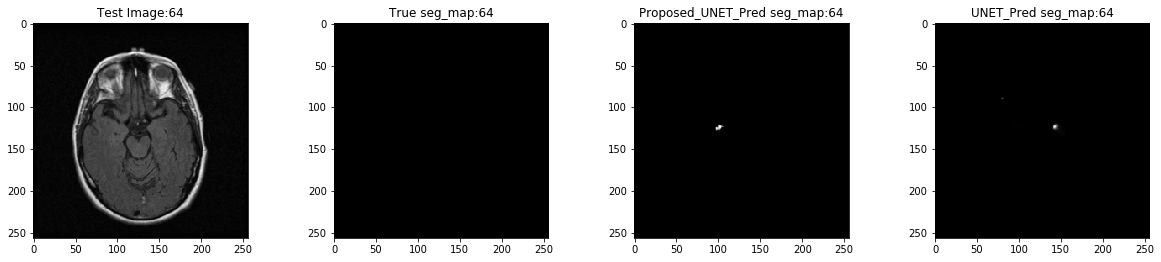

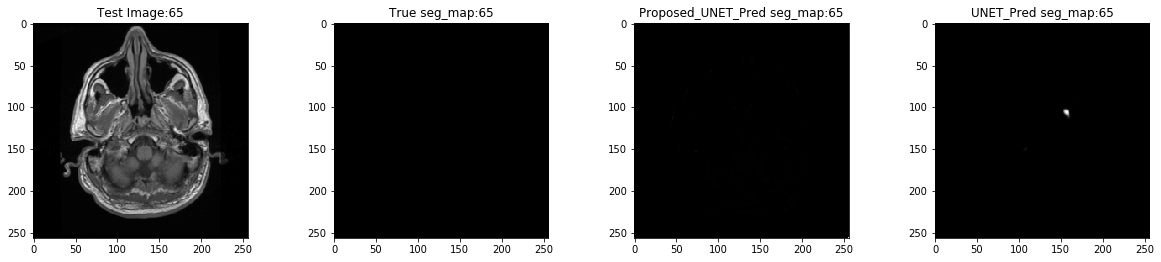

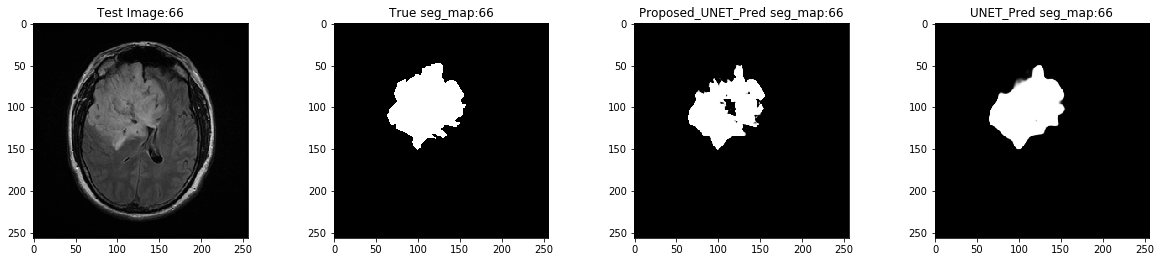

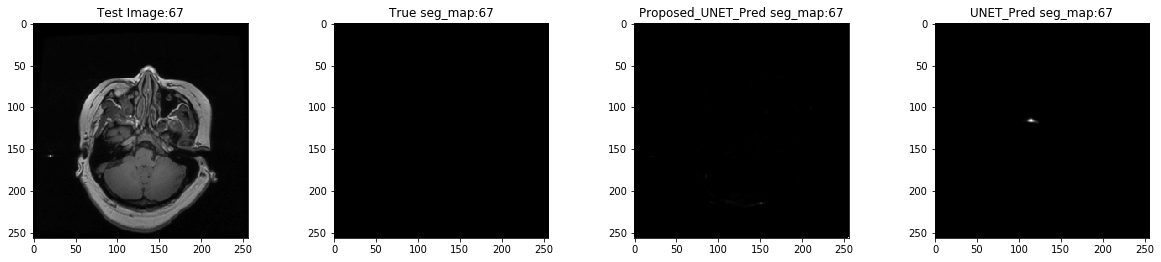

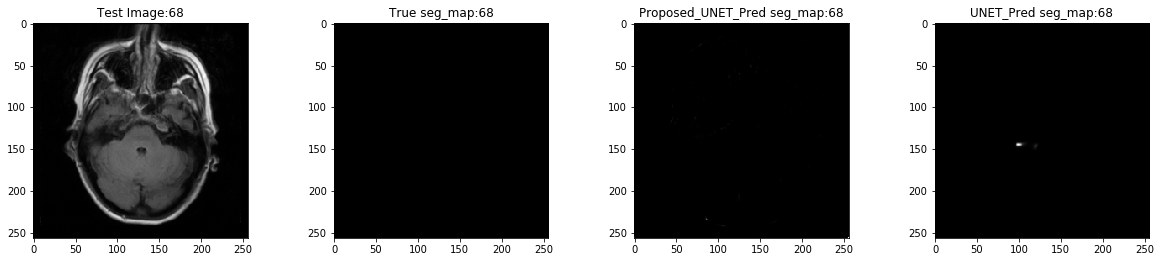

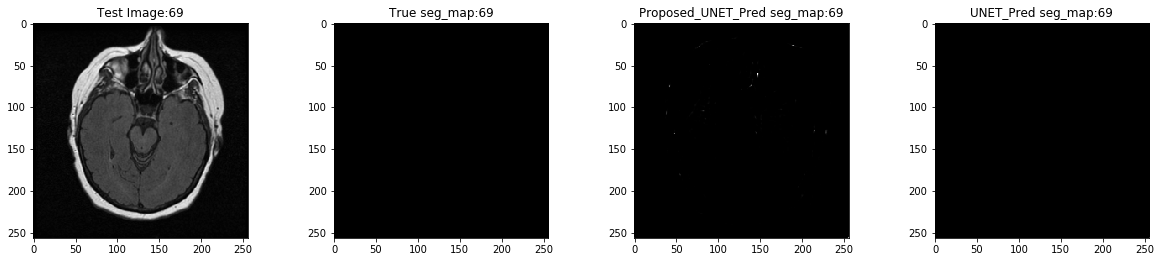

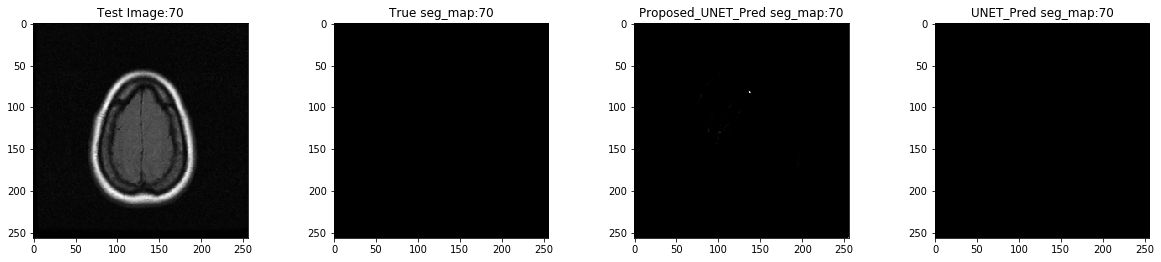

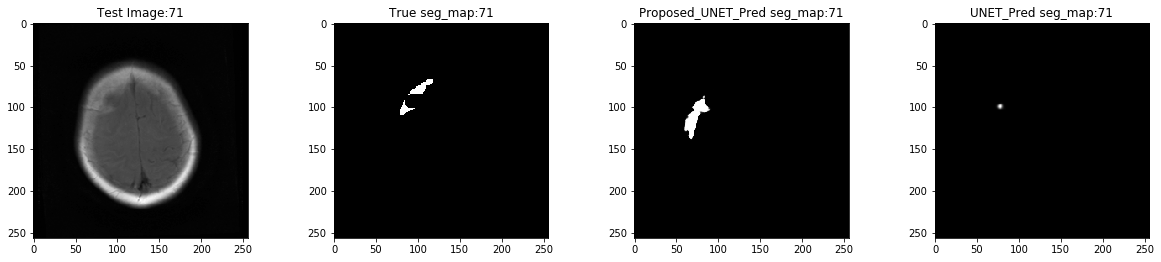

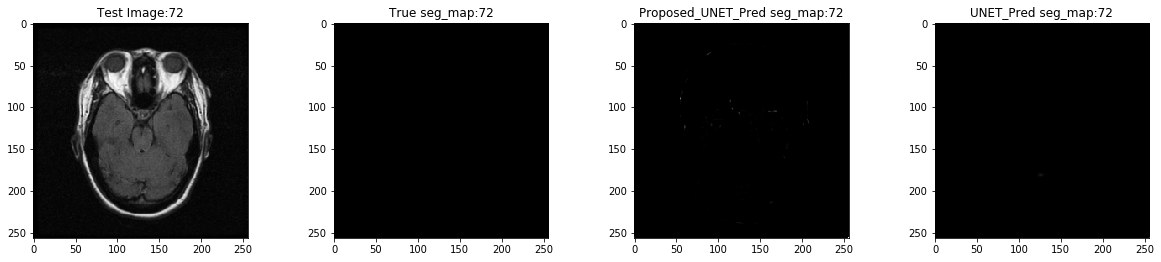

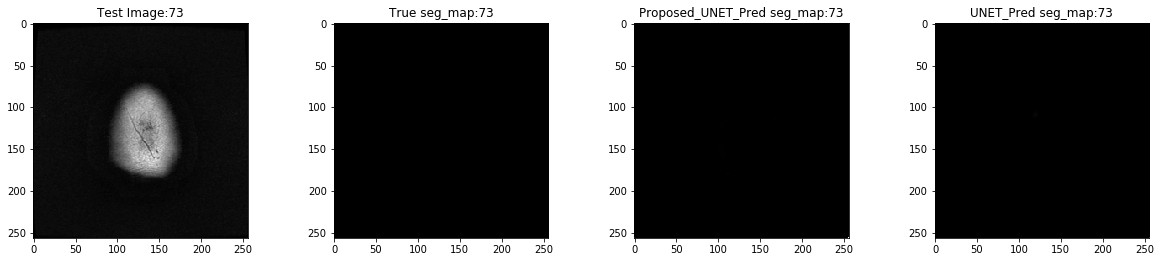

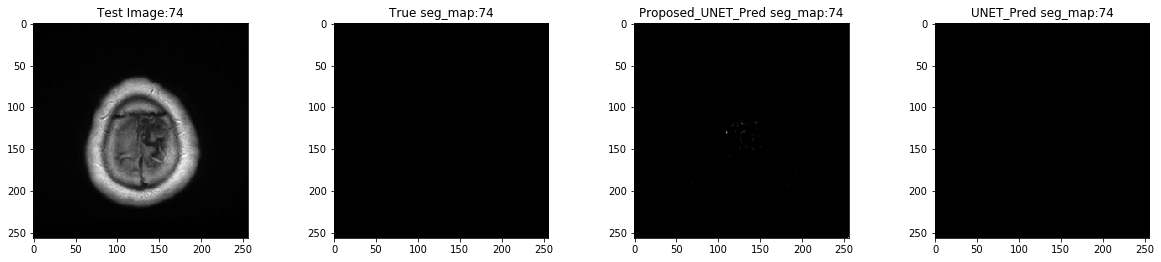

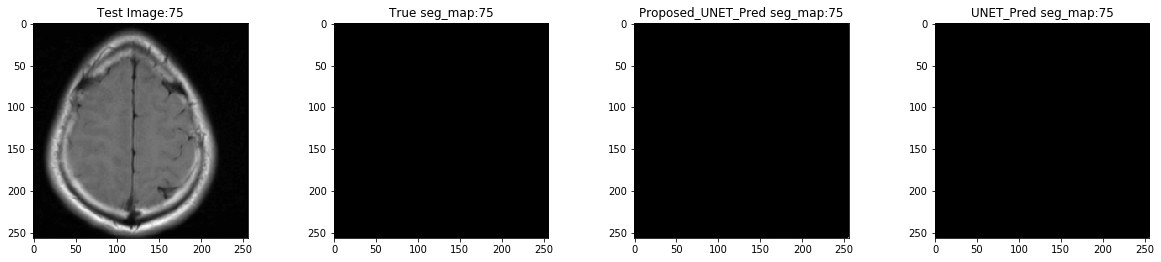

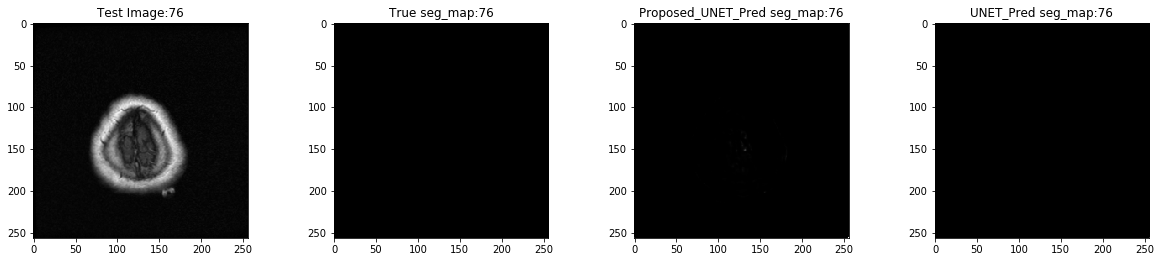

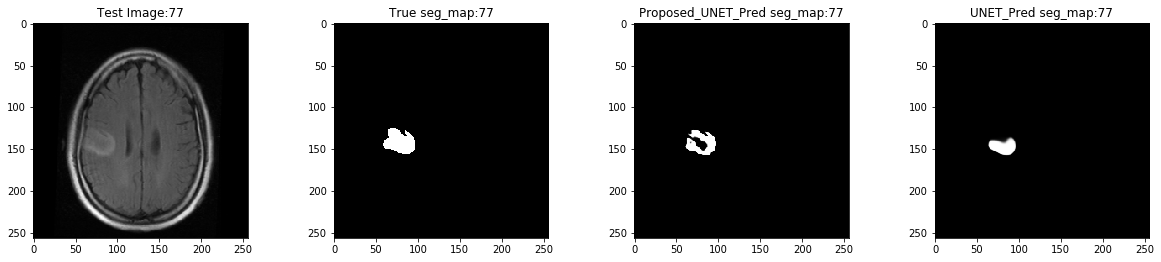

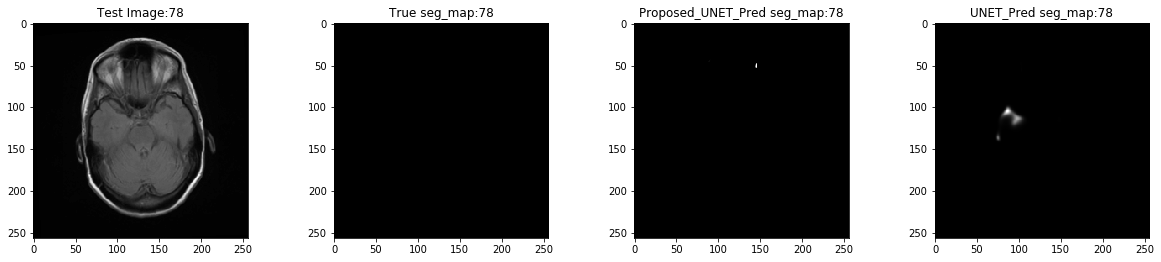

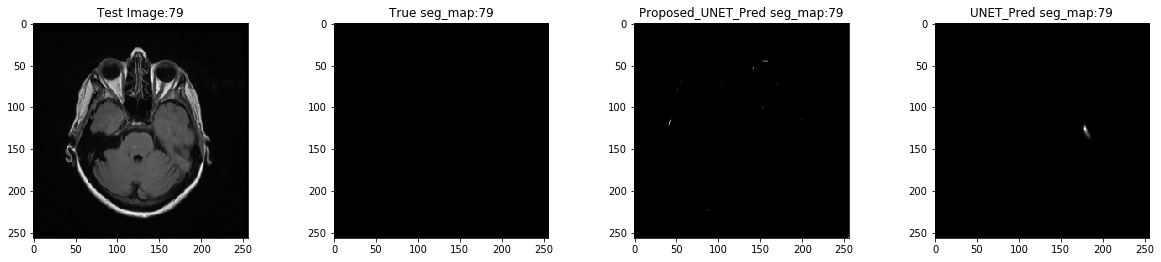

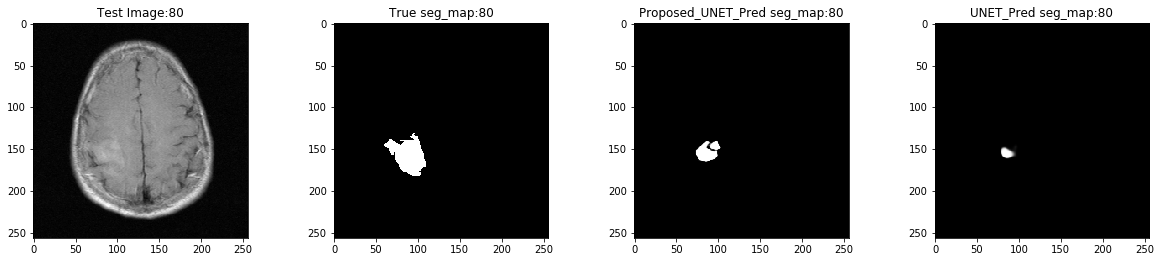

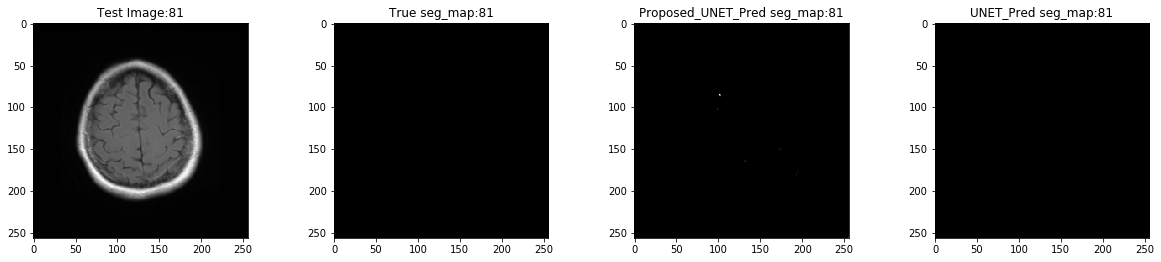

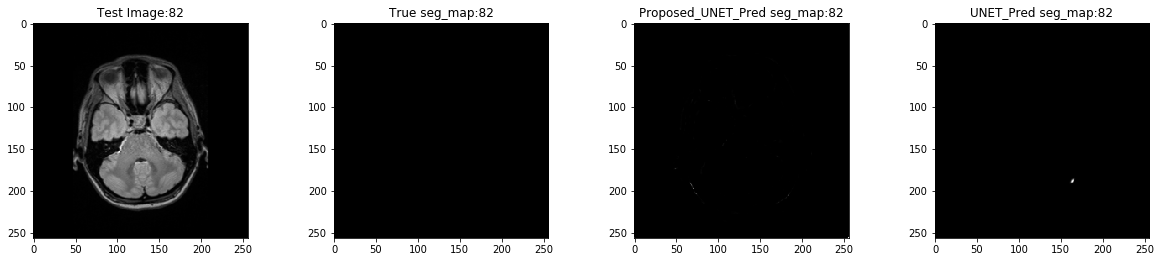

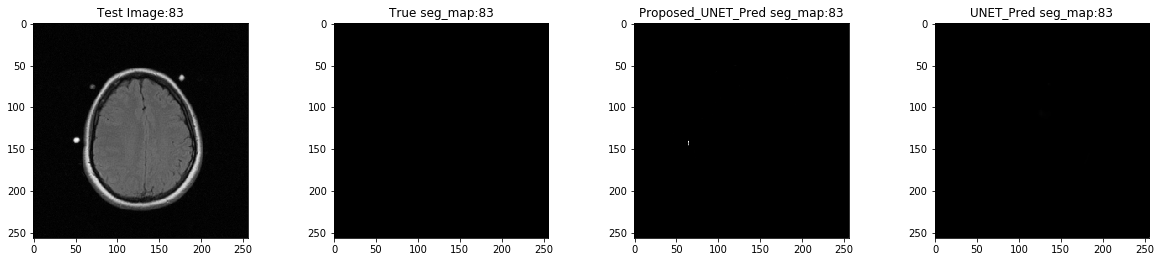

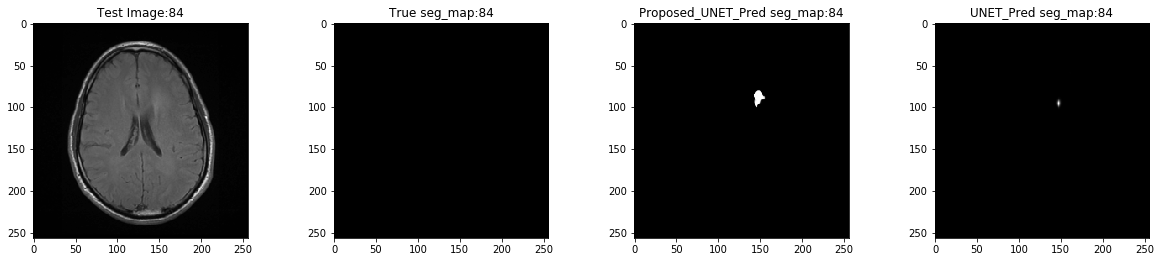

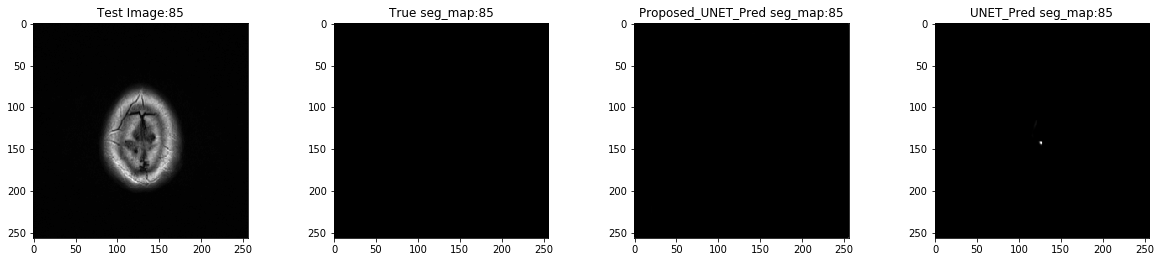

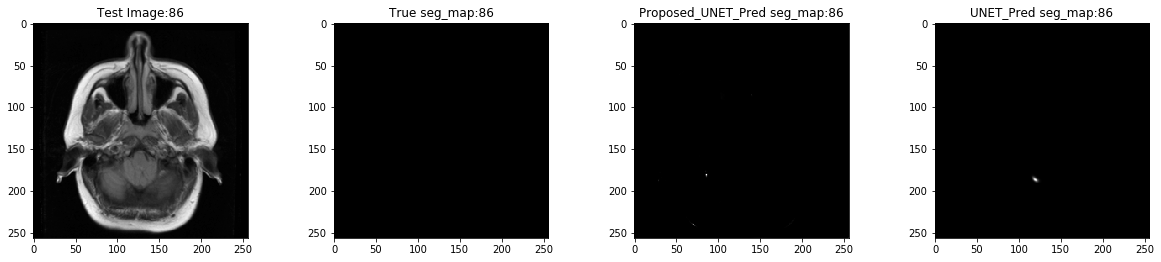

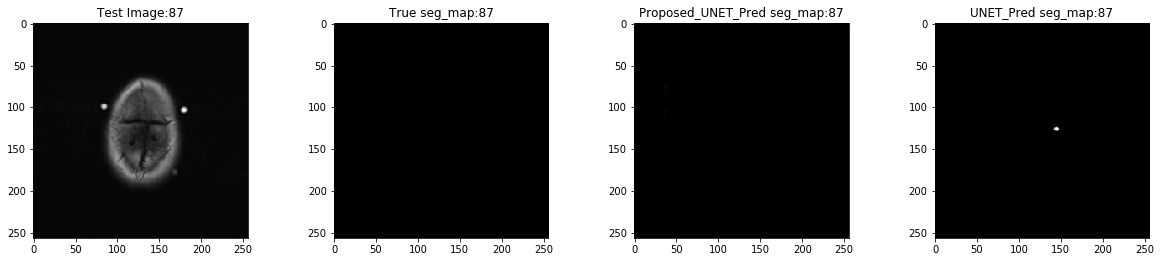

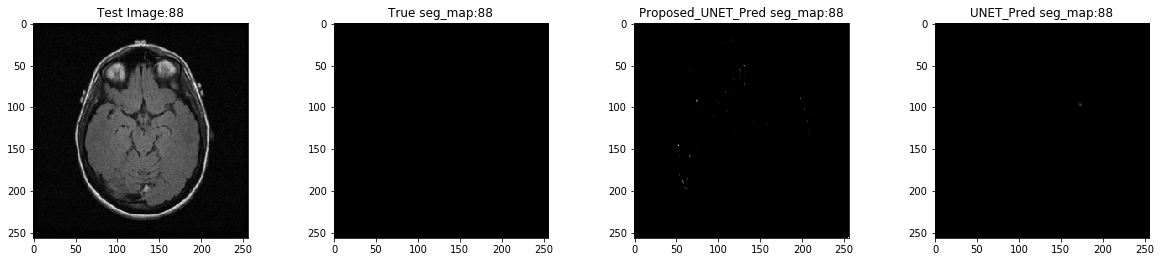

In [0]:

for i in range(len(pred)):
        fig = plt.figure(figsize=(20,15))
        fig.subplots_adjust(hspace=0.6, wspace=0.4)

        ax = fig.add_subplot(1, 4, 1)
        plt.title(f'Test Image:{i}')
        ax.imshow(np.reshape(Test_images[i]*255, (imagesize,imagesize)), cmap="gray")

        ax = fig.add_subplot(1, 4, 2)
        plt.title(f'True seg_map:{i}')
        ax.imshow(np.reshape(Test_masks[i]*255, (imagesize,imagesize)), cmap="gray")

        ax = fig.add_subplot(1, 4, 3)
        plt.title(f'Proposed_UNET_Pred seg_map:{i}')
        ax.imshow(np.reshape(pred[i]*255, (imagesize,imagesize)), cmap="gray")

        ax = fig.add_subplot(1,4, 4)
        plt.title(f'UNET_Pred seg_map:{i}')
        ax.imshow(np.reshape(pred_unet[i]*255, (imagesize,imagesize)), cmap="gray")